In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import holidays

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid, GridSearchCV
from scipy import stats
from tqdm import tqdm

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics



# Parcing data

In [100]:
# парсинг ключевой ставки в df
URL = 'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=' + date.today().strftime('%d.%m.%Y')

data = requests.get(URL).text

bs4 = BeautifulSoup(data, "html.parser")
table = bs4.find_all("table")

df = pd.read_html(str(table))[0]
df.iloc[:,1:] /= 100

In [101]:
# преобразование столбца дата в формат datetime
df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True)

# перенаименование столбцов
df.columns = ['date', 'key_rate']

In [102]:
# общая информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2639 entries, 0 to 2638
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2639 non-null   datetime64[ns]
 1   key_rate  2639 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 41.4 KB


In [103]:
# основные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

,key_rate
count,2639.000000
mean,8.719117
std,3.184026
min,4.250000
25%,7.000000
50%,7.750000
75%,10.500000
max,20.000000


In [104]:
df[:5]

,date,key_rate
0,2024-04-10,16.0
1,2024-04-09,16.0
2,2024-04-08,16.0
3,2024-04-05,16.0
4,2024-04-04,16.0


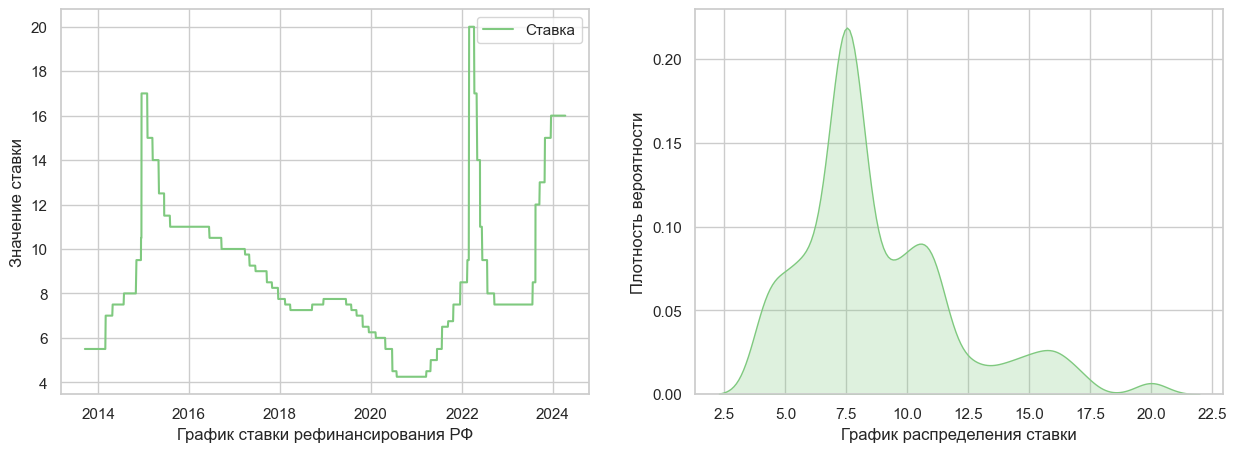

In [105]:
# рисуем график курса ключевой ствки ЦБ РФ и график распределения
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.set_theme(style="whitegrid", palette="Accent")

sns.lineplot(x='date', y='key_rate', data=df, label='Ставка', ax=axes[0])
axes[0].set_xlabel('График ставки рефинансирования РФ')
axes[0].set_ylabel('Значение ставки')
axes[0].legend(loc='best')
axes[0].grid(True)

sns.kdeplot(x=df['key_rate'], ax=axes[1], fill=True)
axes[1].grid(True)
axes[1].set_xlabel('График распределения ставки')
axes[1].set_ylabel('Плотность вероятности')
plt.show()

# EDA

In [106]:
# проверка на нормальное или ненормальное распределение.
test_shapiro = stats.shapiro(df['key_rate'])

print(test_shapiro)

if test_shapiro.pvalue < 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

ShapiroResult(statistic=0.903438925743103, pvalue=5.846601709461748e-38)
Распределение не нормальное


In [107]:
def create_features(data, col_datetime):
    """Создание сезонов и дней недели"""

    data = data.copy()
    data['weekday'] = data[col_datetime].dt.day_name().astype(cat_day)
    data['month'] = data[col_datetime].dt.month_name().astype(cat_month)
    data['year'] = data[col_datetime].dt.year
    data['quarter'] = data['date'].dt.quarter
    data['date_offset'] = (data[col_datetime].dt.month * 100 + data.date.dt.day - 320) % 1300
    data['season'] = data[col_datetime].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'})
    
    return data

cat_day = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered= True)
cat_month = CategoricalDtype(categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered= True)

df_features = create_features(data=df, col_datetime='date')

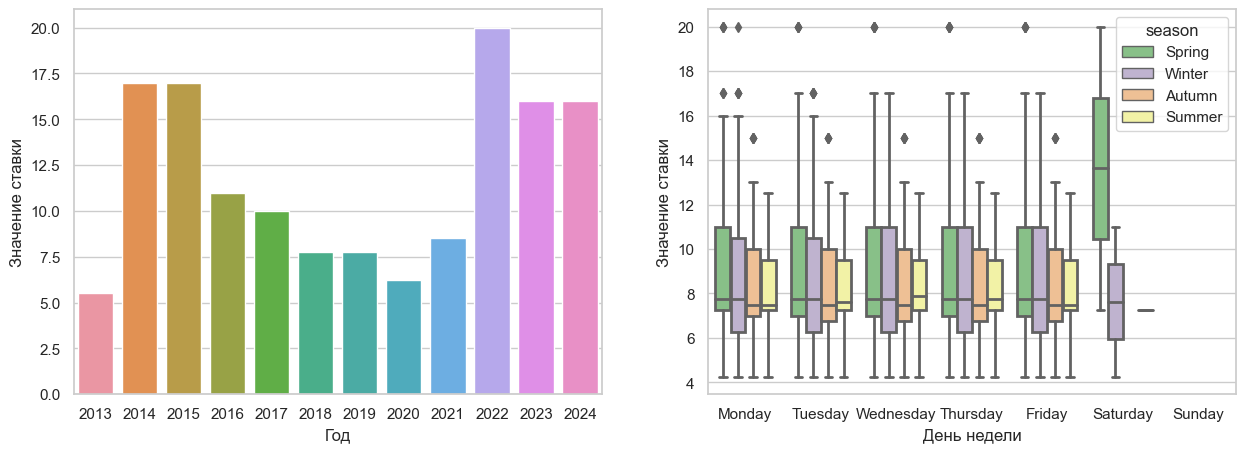

In [108]:
# рисуем графики для анализа
figure, axes = plt.subplots(1, 2, figsize=(15, 5))

year_group = pd.DataFrame(df_features.groupby('year')['key_rate'].max()).reset_index().sort_values('key_rate')

sns.barplot(data=year_group, x='year', y='key_rate', ax=axes[0])
axes[0].set_xlabel('Год')
axes[0].set_ylabel('Значение ставки')

sns.boxplot(data=df_features, x='weekday', y='key_rate', hue='season', ax=axes[1], linewidth=2)
axes[1].set_xlabel('День недели')
axes[1].set_ylabel('Значение ставки')

plt.show()



In [109]:
# дропаем редкие субботние ключевые ставки
drop_trash = df_features[(df_features.weekday == 'Saturday')].index
df = df[~df.index.isin(drop_trash)]
df = df.reset_index(drop=True)

In [110]:
# перенаименование названия колонок для prophet
df.columns = ['ds', 'y']

# период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)


In [111]:
# сортируем данные по возрастанию для корректного отображения разделения графика
df = df.sort_values('ds')
df = df.reset_index(drop=True)

In [112]:
# разделение данных на train, test
df_train = df[:-pred_days]
df_test = df[-pred_days:]


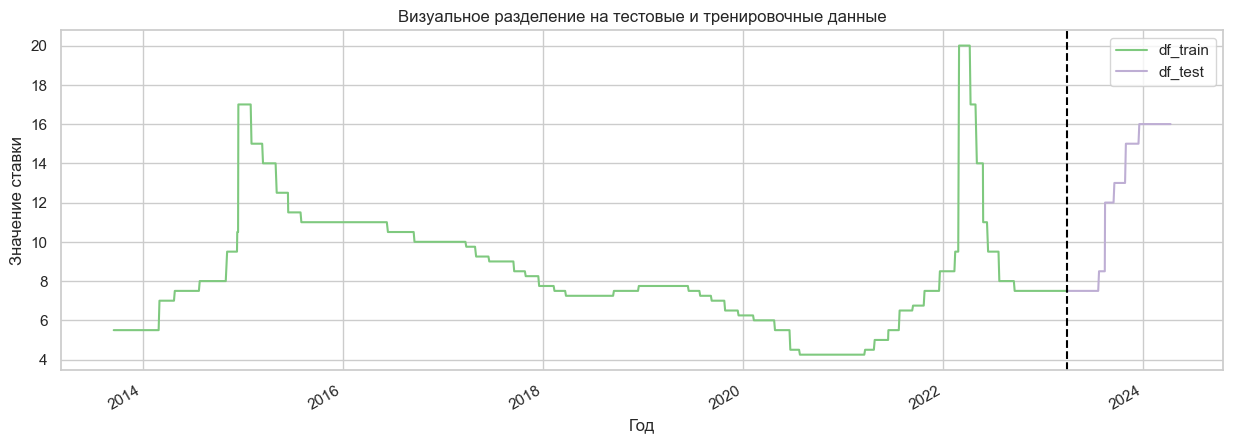

In [113]:
#отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

In [114]:
# обучение модели на train
model = Prophet()
model.fit(df_train)

01:58:42 - cmdstanpy - INFO - Chain [1] start processing
01:58:43 - cmdstanpy - INFO - Chain [1] done processing


In [115]:
future = model.make_future_dataframe(periods=pred_days, freq='D')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2629,2023-12-13,11.898469,9.725853,14.179115
2630,2023-12-14,11.935230,9.709156,14.354788
2631,2023-12-15,11.975237,9.359630,14.230063
2632,2023-12-16,12.754717,10.424082,15.007494
2633,2023-12-17,12.795356,10.355676,15.233195


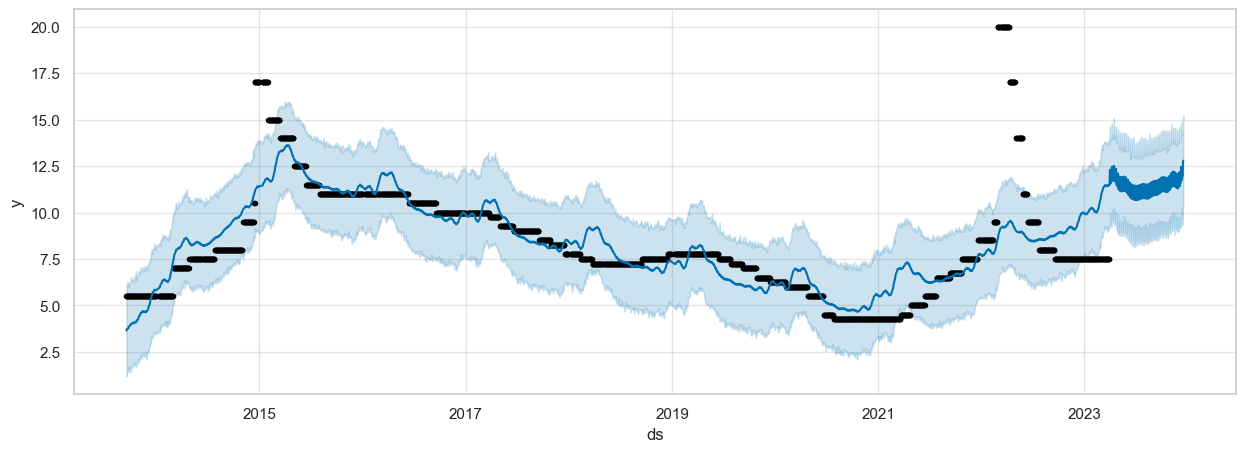

In [116]:
# смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model.plot(forecast,ax=ax)
plt.show()

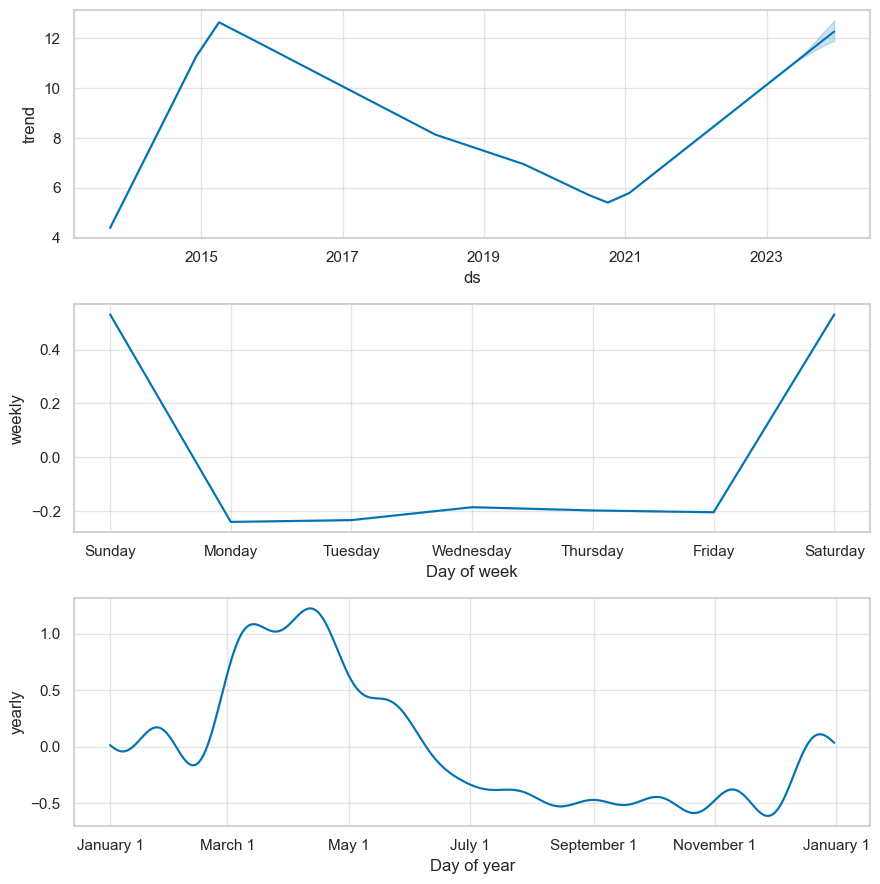

In [117]:
# смотрим тренд, годовые и сезонные признаки
fig = model.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [118]:
df_test_forecast = model.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
258,2024-04-04,13.881157,11.422411,16.333977
259,2024-04-05,13.898541,11.378858,16.408857
260,2024-04-08,13.926319,11.566026,16.447817
261,2024-04-09,13.949392,11.469179,16.509415
262,2024-04-10,14.010482,11.578773,16.537314


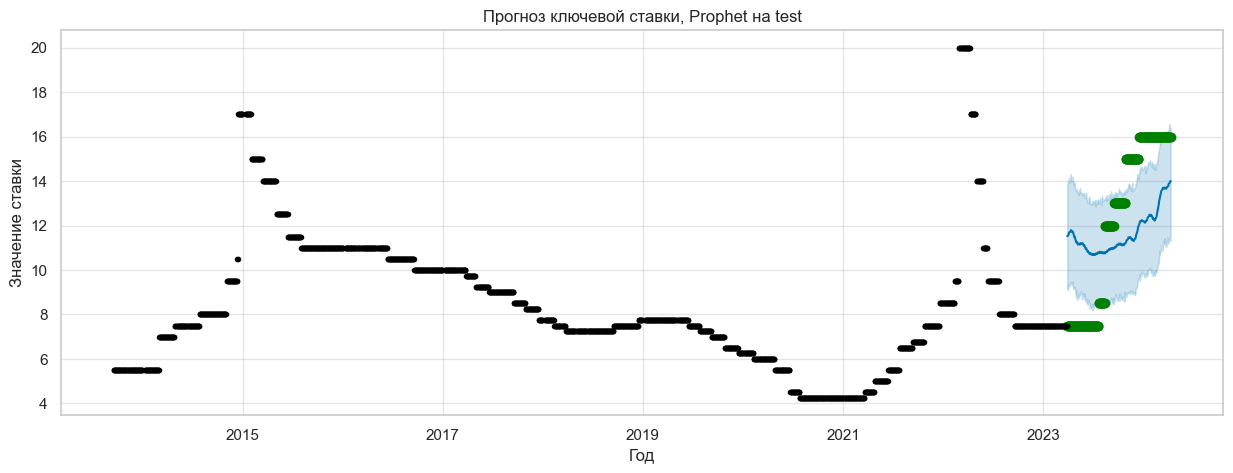

In [119]:
# смотрим совпадение фактического курса с предсказанным курсом prophet обученным на train, проверка модели
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model.predict(df_test)
fig = model.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet на test')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

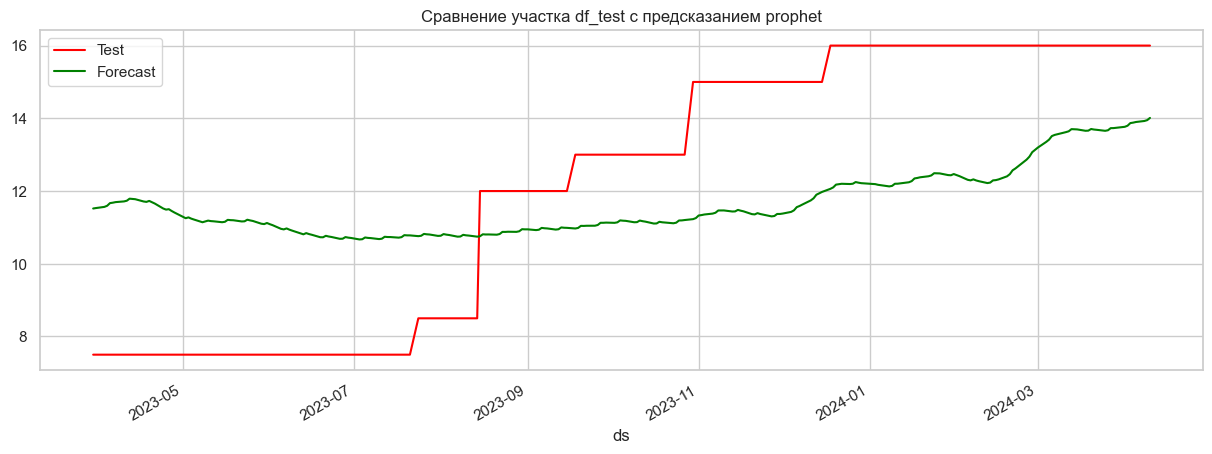

In [120]:
# сравнение участка df_test с предсказанием prophet
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet')
plt.show()

In [121]:
# просмотр метрик модели обученной на train в сравнени с прогнозом
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,2.963564,0.27715,9.632522,3.10363


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, такие как праздники

In [122]:
# создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [123]:
# тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

01:58:47 - cmdstanpy - INFO - Chain [1] start processing
01:58:47 - cmdstanpy - INFO - Chain [1] done processing


In [124]:
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2629,2023-12-13,11.904685,9.355859,14.335395
2630,2023-12-14,11.938390,9.728015,14.425239
2631,2023-12-15,11.987122,9.654629,14.288199
2632,2023-12-16,12.799523,10.527400,15.458196
2633,2023-12-17,12.845124,10.594835,15.124227


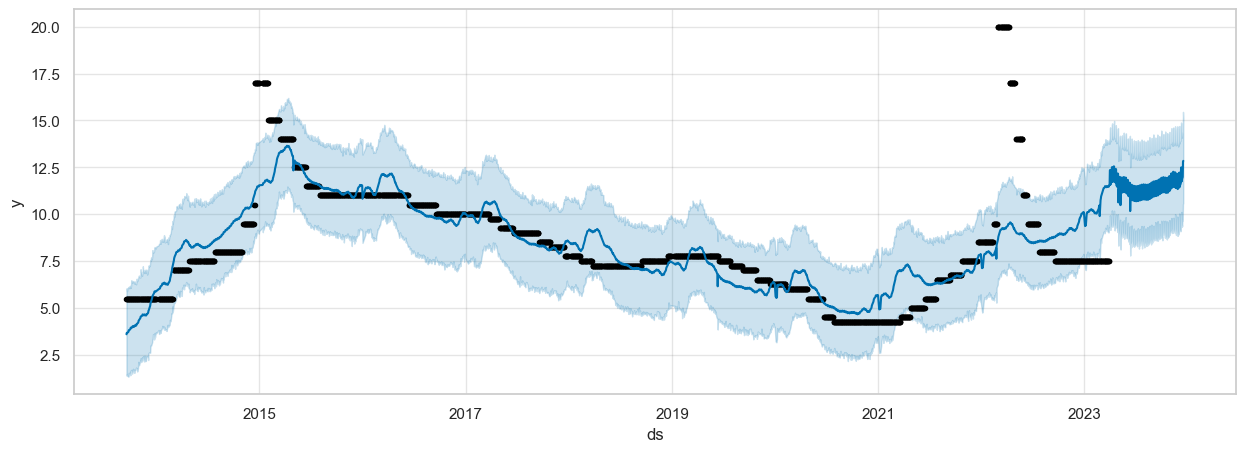

In [125]:
# смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

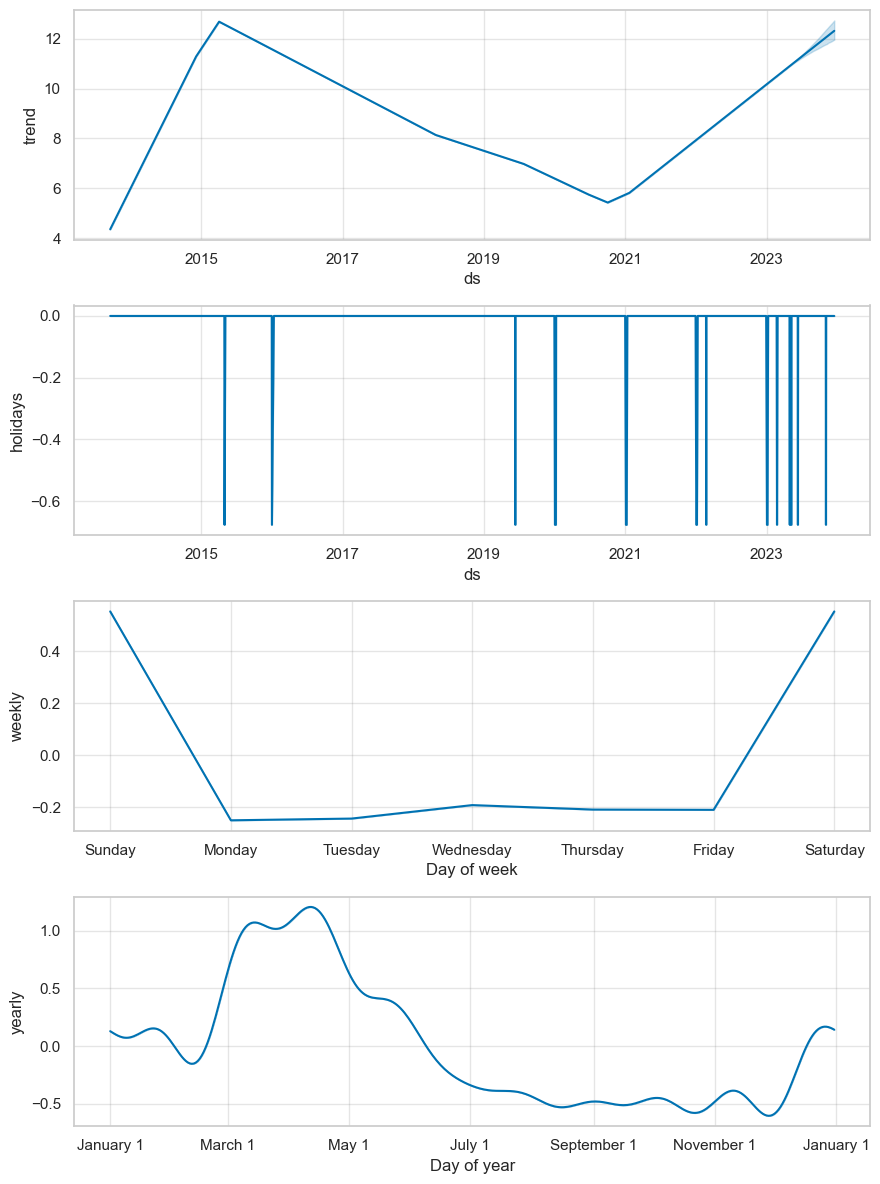

In [126]:
# смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

In [127]:
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
258,2024-04-04,13.900780,11.423844,16.262719
259,2024-04-05,13.922746,11.467141,16.461943
260,2024-04-08,13.943944,11.480406,16.359046
261,2024-04-09,13.966819,11.491214,16.429323
262,2024-04-10,14.031972,11.527256,16.461636


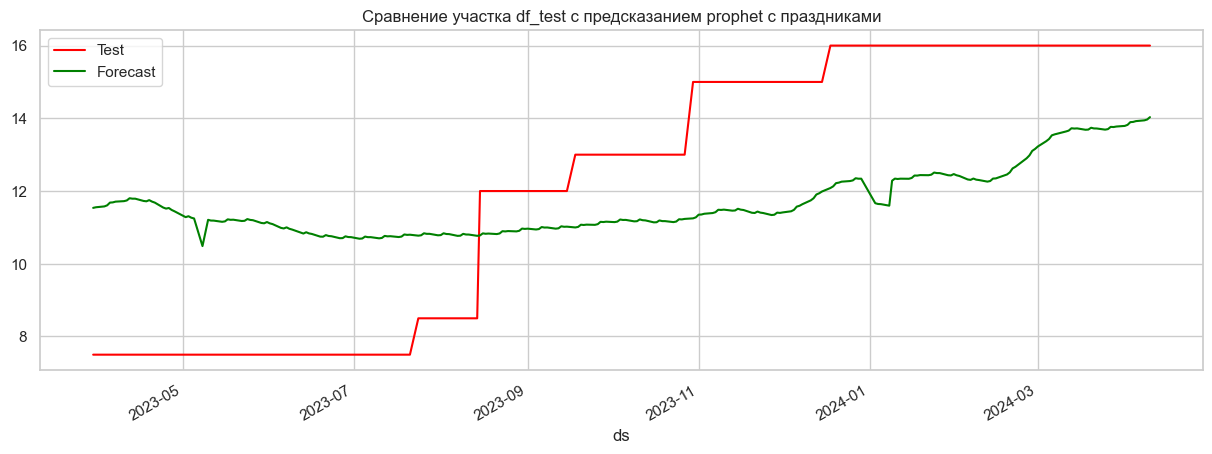

In [128]:
# сравнение участка df_test с предсказанием prophet
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [129]:
# сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,2.963564,0.277150,9.632522,3.103630
0,Prophet_with_holidays,2.956280,0.276899,9.613325,3.100536


Из метрик и графиков видим, что модель с праздниками показывает результаты немного хуже

# Тюнинг тест модели

In [130]:
# создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5, 10.0], 
    'holidays_prior_scale': [0.01, 0.1, 1.0, 5, 10.0],
    'seasonality_mode': ('multiplicative','additive'),
    'changepoint_range': [0.7, 0.8, 0.95]
    #'daily_seasonality': (True, False),
    #'weekly_seasonality': (True, False),
    #'yearly_seasonality': (True, False),
    }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 600


In [131]:
# Создаем пустой DataFrame для сохранения метрик
model_grid_metrics = pd.DataFrame()
model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# Проходимся по сетке гиперпараметров
for p in tqdm(grid):
    print(p)
#for p in grid:
#    print(p)
    
    # Создаем модель Prophet с текущими гиперпараметрами
    model_grid = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        holidays_prior_scale = p['holidays_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        changepoint_range = p['changepoint_range'],
        #daily_seasonality = p['daily_seasonality'],
        #weekly_seasonality = p['weekly_seasonality'],
        #yearly_seasonality = p['yearly_seasonality'],
        holidays=holiday,
    )

    # Добавляем праздники в модель
    model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель данными
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем метрики и добавляем новую строку в DataFrame
    model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
    model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)



  0%|          | 0/600 [00:00<?, ?it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:58:51 - cmdstanpy - INFO - Chain [1] start processing
01:58:51 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/600 [00:00<09:38,  1.03it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:58:52 - cmdstanpy - INFO - Chain [1] start processing
01:58:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/600 [00:01<08:45,  1.14it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:58:53 - cmdstanpy - INFO - Chain [1] start processing
01:58:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/600 [00:02<08:37,  1.15it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


01:58:54 - cmdstanpy - INFO - Chain [1] start processing
01:58:54 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 4/600 [00:03<08:13,  1.21it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:58:55 - cmdstanpy - INFO - Chain [1] start processing
01:58:55 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/600 [00:04<08:14,  1.20it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:58:55 - cmdstanpy - INFO - Chain [1] start processing
01:58:56 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/600 [00:05<08:13,  1.20it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:58:56 - cmdstanpy - INFO - Chain [1] start processing
01:58:56 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 7/600 [00:05<08:10,  1.21it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:58:57 - cmdstanpy - INFO - Chain [1] start processing
01:58:57 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 8/600 [00:06<08:36,  1.15it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


01:58:58 - cmdstanpy - INFO - Chain [1] start processing
01:58:58 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 9/600 [00:07<08:17,  1.19it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:58:59 - cmdstanpy - INFO - Chain [1] start processing
01:58:59 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 10/600 [00:08<09:27,  1.04it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:59:00 - cmdstanpy - INFO - Chain [1] start processing
01:59:00 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 11/600 [00:09<08:55,  1.10it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:59:01 - cmdstanpy - INFO - Chain [1] start processing
01:59:01 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 12/600 [00:10<08:46,  1.12it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:59:02 - cmdstanpy - INFO - Chain [1] start processing
01:59:02 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 13/600 [00:11<09:22,  1.04it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


01:59:03 - cmdstanpy - INFO - Chain [1] start processing
01:59:03 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 14/600 [00:12<09:33,  1.02it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:59:04 - cmdstanpy - INFO - Chain [1] start processing
01:59:04 - cmdstanpy - INFO - Chain [1] done processing
  2%|▎         | 15/600 [00:13<09:40,  1.01it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:59:05 - cmdstanpy - INFO - Chain [1] start processing
01:59:05 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 16/600 [00:14<09:38,  1.01it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:59:06 - cmdstanpy - INFO - Chain [1] start processing
01:59:07 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 17/600 [00:15<10:31,  1.08s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:59:07 - cmdstanpy - INFO - Chain [1] start processing
01:59:07 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 18/600 [00:16<09:44,  1.00s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


01:59:08 - cmdstanpy - INFO - Chain [1] start processing
01:59:08 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 19/600 [00:17<09:10,  1.05it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:59:09 - cmdstanpy - INFO - Chain [1] start processing
01:59:09 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 20/600 [00:18<08:43,  1.11it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:59:10 - cmdstanpy - INFO - Chain [1] start processing
01:59:10 - cmdstanpy - INFO - Chain [1] done processing
  4%|▎         | 21/600 [00:19<08:20,  1.16it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:59:10 - cmdstanpy - INFO - Chain [1] start processing
01:59:11 - cmdstanpy - INFO - Chain [1] done processing
  4%|▎         | 22/600 [00:20<08:14,  1.17it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:59:11 - cmdstanpy - INFO - Chain [1] start processing
01:59:11 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 23/600 [00:20<08:03,  1.19it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


01:59:12 - cmdstanpy - INFO - Chain [1] start processing
01:59:12 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 24/600 [00:21<07:50,  1.22it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:59:13 - cmdstanpy - INFO - Chain [1] start processing
01:59:13 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 25/600 [00:22<08:48,  1.09it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:59:14 - cmdstanpy - INFO - Chain [1] start processing
01:59:14 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 26/600 [00:23<09:01,  1.06it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:59:15 - cmdstanpy - INFO - Chain [1] start processing
01:59:15 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 27/600 [00:24<09:24,  1.01it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:59:16 - cmdstanpy - INFO - Chain [1] start processing
01:59:16 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 28/600 [00:25<09:21,  1.02it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


01:59:17 - cmdstanpy - INFO - Chain [1] start processing
01:59:17 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 29/600 [00:26<08:51,  1.07it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:59:18 - cmdstanpy - INFO - Chain [1] start processing
01:59:18 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 30/600 [00:27<09:08,  1.04it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:59:19 - cmdstanpy - INFO - Chain [1] start processing
01:59:19 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 31/600 [00:28<09:05,  1.04it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:59:20 - cmdstanpy - INFO - Chain [1] start processing
01:59:20 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 32/600 [00:29<08:55,  1.06it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:59:21 - cmdstanpy - INFO - Chain [1] start processing
01:59:21 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 33/600 [00:30<09:20,  1.01it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


01:59:22 - cmdstanpy - INFO - Chain [1] start processing
01:59:22 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 34/600 [00:31<09:36,  1.02s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:59:23 - cmdstanpy - INFO - Chain [1] start processing
01:59:23 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 35/600 [00:32<09:22,  1.00it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:59:24 - cmdstanpy - INFO - Chain [1] start processing
01:59:24 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 36/600 [00:33<09:32,  1.01s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:59:25 - cmdstanpy - INFO - Chain [1] start processing
01:59:25 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 37/600 [00:34<09:14,  1.01it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:59:26 - cmdstanpy - INFO - Chain [1] start processing
01:59:26 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 38/600 [00:35<09:05,  1.03it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


01:59:27 - cmdstanpy - INFO - Chain [1] start processing
01:59:27 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 39/600 [00:36<08:45,  1.07it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:59:28 - cmdstanpy - INFO - Chain [1] start processing
01:59:28 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 40/600 [00:37<08:31,  1.09it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:59:29 - cmdstanpy - INFO - Chain [1] start processing
01:59:29 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 41/600 [00:38<08:31,  1.09it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:59:29 - cmdstanpy - INFO - Chain [1] start processing
01:59:30 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 42/600 [00:38<08:09,  1.14it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:59:30 - cmdstanpy - INFO - Chain [1] start processing
01:59:30 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 43/600 [00:39<08:09,  1.14it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


01:59:31 - cmdstanpy - INFO - Chain [1] start processing
01:59:31 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 44/600 [00:40<07:52,  1.18it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:59:32 - cmdstanpy - INFO - Chain [1] start processing
01:59:32 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 45/600 [00:41<07:45,  1.19it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:59:33 - cmdstanpy - INFO - Chain [1] start processing
01:59:33 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 46/600 [00:42<07:53,  1.17it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:59:34 - cmdstanpy - INFO - Chain [1] start processing
01:59:34 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 47/600 [00:43<08:17,  1.11it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:59:35 - cmdstanpy - INFO - Chain [1] start processing
01:59:35 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 48/600 [00:44<08:18,  1.11it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


01:59:36 - cmdstanpy - INFO - Chain [1] start processing
01:59:36 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 49/600 [00:45<08:43,  1.05it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:59:36 - cmdstanpy - INFO - Chain [1] start processing
01:59:37 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 50/600 [00:46<08:22,  1.09it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:59:37 - cmdstanpy - INFO - Chain [1] start processing
01:59:37 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 51/600 [00:46<08:00,  1.14it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:59:38 - cmdstanpy - INFO - Chain [1] start processing
01:59:38 - cmdstanpy - INFO - Chain [1] done processing
  9%|▊         | 52/600 [00:47<07:59,  1.14it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:59:39 - cmdstanpy - INFO - Chain [1] start processing
01:59:39 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 53/600 [00:48<07:53,  1.16it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


01:59:40 - cmdstanpy - INFO - Chain [1] start processing
01:59:40 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 54/600 [00:49<07:43,  1.18it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:59:41 - cmdstanpy - INFO - Chain [1] start processing
01:59:41 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 55/600 [00:50<07:51,  1.16it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:59:42 - cmdstanpy - INFO - Chain [1] start processing
01:59:42 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 56/600 [00:51<08:02,  1.13it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:59:42 - cmdstanpy - INFO - Chain [1] start processing
01:59:43 - cmdstanpy - INFO - Chain [1] done processing
 10%|▉         | 57/600 [00:52<07:59,  1.13it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:59:43 - cmdstanpy - INFO - Chain [1] start processing
01:59:44 - cmdstanpy - INFO - Chain [1] done processing
 10%|▉         | 58/600 [00:53<07:58,  1.13it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


01:59:44 - cmdstanpy - INFO - Chain [1] start processing
01:59:44 - cmdstanpy - INFO - Chain [1] done processing
 10%|▉         | 59/600 [00:53<07:41,  1.17it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:59:45 - cmdstanpy - INFO - Chain [1] start processing
01:59:45 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 60/600 [00:54<07:40,  1.17it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:59:46 - cmdstanpy - INFO - Chain [1] start processing
01:59:46 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 61/600 [00:55<07:35,  1.18it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


01:59:47 - cmdstanpy - INFO - Chain [1] start processing
01:59:47 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 62/600 [00:56<07:46,  1.15it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


01:59:48 - cmdstanpy - INFO - Chain [1] start processing
01:59:48 - cmdstanpy - INFO - Chain [1] done processing
 10%|█         | 63/600 [00:57<08:01,  1.11it/s]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


01:59:49 - cmdstanpy - INFO - Chain [1] start processing
01:59:50 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 64/600 [00:59<10:09,  1.14s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


01:59:50 - cmdstanpy - INFO - Chain [1] start processing
01:59:51 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 65/600 [01:00<10:08,  1.14s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


01:59:52 - cmdstanpy - INFO - Chain [1] start processing
01:59:52 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 66/600 [01:01<10:49,  1.22s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


01:59:53 - cmdstanpy - INFO - Chain [1] start processing
01:59:53 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 67/600 [01:02<10:18,  1.16s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


01:59:54 - cmdstanpy - INFO - Chain [1] start processing
01:59:54 - cmdstanpy - INFO - Chain [1] done processing
 11%|█▏        | 68/600 [01:03<10:01,  1.13s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


01:59:55 - cmdstanpy - INFO - Chain [1] start processing
01:59:56 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 69/600 [01:05<10:39,  1.20s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


01:59:57 - cmdstanpy - INFO - Chain [1] start processing
01:59:58 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 70/600 [01:07<13:29,  1.53s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


01:59:59 - cmdstanpy - INFO - Chain [1] start processing
01:59:59 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 71/600 [01:08<12:45,  1.45s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:00:00 - cmdstanpy - INFO - Chain [1] start processing
02:00:00 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 72/600 [01:09<12:08,  1.38s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:00:01 - cmdstanpy - INFO - Chain [1] start processing
02:00:01 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 73/600 [01:11<11:33,  1.32s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:00:03 - cmdstanpy - INFO - Chain [1] start processing
02:00:03 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▏        | 74/600 [01:12<11:44,  1.34s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:00:04 - cmdstanpy - INFO - Chain [1] start processing
02:00:04 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 75/600 [01:13<11:48,  1.35s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:00:05 - cmdstanpy - INFO - Chain [1] start processing
02:00:06 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 76/600 [01:15<12:01,  1.38s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:00:07 - cmdstanpy - INFO - Chain [1] start processing
02:00:07 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 77/600 [01:16<12:03,  1.38s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:00:09 - cmdstanpy - INFO - Chain [1] start processing
02:00:09 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 78/600 [01:18<13:06,  1.51s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:00:10 - cmdstanpy - INFO - Chain [1] start processing
02:00:10 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 79/600 [01:19<12:45,  1.47s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:00:11 - cmdstanpy - INFO - Chain [1] start processing
02:00:12 - cmdstanpy - INFO - Chain [1] done processing
 13%|█▎        | 80/600 [01:21<12:22,  1.43s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:00:13 - cmdstanpy - INFO - Chain [1] start processing
02:00:13 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▎        | 81/600 [01:22<12:03,  1.39s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:00:14 - cmdstanpy - INFO - Chain [1] start processing
02:00:14 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▎        | 82/600 [01:24<12:27,  1.44s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:00:15 - cmdstanpy - INFO - Chain [1] start processing
02:00:16 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 83/600 [01:25<11:57,  1.39s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:00:17 - cmdstanpy - INFO - Chain [1] start processing
02:00:17 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 84/600 [01:26<11:44,  1.36s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:00:18 - cmdstanpy - INFO - Chain [1] start processing
02:00:18 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 85/600 [01:27<11:44,  1.37s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:00:20 - cmdstanpy - INFO - Chain [1] start processing
02:00:20 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 86/600 [01:29<12:03,  1.41s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:00:21 - cmdstanpy - INFO - Chain [1] start processing
02:00:21 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 87/600 [01:30<11:41,  1.37s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:00:22 - cmdstanpy - INFO - Chain [1] start processing
02:00:22 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▍        | 88/600 [01:32<11:41,  1.37s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:00:24 - cmdstanpy - INFO - Chain [1] start processing
02:00:24 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▍        | 89/600 [01:33<12:06,  1.42s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:00:25 - cmdstanpy - INFO - Chain [1] start processing
02:00:25 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 90/600 [01:34<11:43,  1.38s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:00:26 - cmdstanpy - INFO - Chain [1] start processing
02:00:27 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 91/600 [01:36<11:35,  1.37s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:00:28 - cmdstanpy - INFO - Chain [1] start processing
02:00:28 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 92/600 [01:37<11:51,  1.40s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:00:29 - cmdstanpy - INFO - Chain [1] start processing
02:00:30 - cmdstanpy - INFO - Chain [1] done processing
 16%|█▌        | 93/600 [01:39<11:52,  1.41s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:00:31 - cmdstanpy - INFO - Chain [1] start processing
02:00:31 - cmdstanpy - INFO - Chain [1] done processing
 16%|█▌        | 94/600 [01:40<11:50,  1.40s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:00:32 - cmdstanpy - INFO - Chain [1] start processing
02:00:32 - cmdstanpy - INFO - Chain [1] done processing
 16%|█▌        | 95/600 [01:41<11:36,  1.38s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:00:33 - cmdstanpy - INFO - Chain [1] start processing
02:00:34 - cmdstanpy - INFO - Chain [1] done processing
 16%|█▌        | 96/600 [01:43<11:31,  1.37s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:00:35 - cmdstanpy - INFO - Chain [1] start processing
02:00:35 - cmdstanpy - INFO - Chain [1] done processing
 16%|█▌        | 97/600 [01:44<11:10,  1.33s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:00:36 - cmdstanpy - INFO - Chain [1] start processing
02:00:36 - cmdstanpy - INFO - Chain [1] done processing
 16%|█▋        | 98/600 [01:45<10:56,  1.31s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:00:37 - cmdstanpy - INFO - Chain [1] start processing
02:00:38 - cmdstanpy - INFO - Chain [1] done processing
 16%|█▋        | 99/600 [01:47<11:03,  1.32s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:00:39 - cmdstanpy - INFO - Chain [1] start processing
02:00:39 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 100/600 [01:48<11:22,  1.37s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:00:40 - cmdstanpy - INFO - Chain [1] start processing
02:00:40 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 101/600 [01:49<11:16,  1.36s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:00:41 - cmdstanpy - INFO - Chain [1] start processing
02:00:42 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 102/600 [01:51<11:34,  1.39s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:00:43 - cmdstanpy - INFO - Chain [1] start processing
02:00:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 103/600 [01:52<11:20,  1.37s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:00:44 - cmdstanpy - INFO - Chain [1] start processing
02:00:44 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 104/600 [01:53<11:00,  1.33s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:00:45 - cmdstanpy - INFO - Chain [1] start processing
02:00:46 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 105/600 [01:55<11:17,  1.37s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:00:47 - cmdstanpy - INFO - Chain [1] start processing
02:00:47 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 106/600 [01:56<11:08,  1.35s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:00:48 - cmdstanpy - INFO - Chain [1] start processing
02:00:48 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 107/600 [01:57<10:54,  1.33s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:00:49 - cmdstanpy - INFO - Chain [1] start processing
02:00:50 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 108/600 [01:59<10:25,  1.27s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:00:51 - cmdstanpy - INFO - Chain [1] start processing
02:00:51 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 109/600 [02:00<10:19,  1.26s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:00:52 - cmdstanpy - INFO - Chain [1] start processing
02:00:52 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 110/600 [02:01<10:18,  1.26s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:00:53 - cmdstanpy - INFO - Chain [1] start processing
02:00:53 - cmdstanpy - INFO - Chain [1] done processing
 18%|█▊        | 111/600 [02:02<10:23,  1.27s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:00:54 - cmdstanpy - INFO - Chain [1] start processing
02:00:55 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▊        | 112/600 [02:04<10:10,  1.25s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:00:56 - cmdstanpy - INFO - Chain [1] start processing
02:00:56 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 113/600 [02:05<10:46,  1.33s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:00:57 - cmdstanpy - INFO - Chain [1] start processing
02:00:57 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 114/600 [02:06<10:35,  1.31s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:00:58 - cmdstanpy - INFO - Chain [1] start processing
02:00:59 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 115/600 [02:08<10:18,  1.27s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:00:59 - cmdstanpy - INFO - Chain [1] start processing
02:01:00 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 116/600 [02:09<10:03,  1.25s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:01:01 - cmdstanpy - INFO - Chain [1] start processing
02:01:01 - cmdstanpy - INFO - Chain [1] done processing
 20%|█▉        | 117/600 [02:10<10:27,  1.30s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:01:02 - cmdstanpy - INFO - Chain [1] start processing
02:01:02 - cmdstanpy - INFO - Chain [1] done processing
 20%|█▉        | 118/600 [02:11<10:15,  1.28s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:01:03 - cmdstanpy - INFO - Chain [1] start processing
02:01:04 - cmdstanpy - INFO - Chain [1] done processing
 20%|█▉        | 119/600 [02:13<10:03,  1.26s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:01:05 - cmdstanpy - INFO - Chain [1] start processing
02:01:05 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 120/600 [02:14<10:01,  1.25s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:01:06 - cmdstanpy - INFO - Chain [1] start processing
02:01:06 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 121/600 [02:15<09:52,  1.24s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:01:07 - cmdstanpy - INFO - Chain [1] start processing
02:01:07 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 122/600 [02:16<10:08,  1.27s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:01:09 - cmdstanpy - INFO - Chain [1] start processing
02:01:09 - cmdstanpy - INFO - Chain [1] done processing
 20%|██        | 123/600 [02:18<10:39,  1.34s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:01:10 - cmdstanpy - INFO - Chain [1] start processing
02:01:10 - cmdstanpy - INFO - Chain [1] done processing
 21%|██        | 124/600 [02:19<10:24,  1.31s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:01:11 - cmdstanpy - INFO - Chain [1] start processing
02:01:11 - cmdstanpy - INFO - Chain [1] done processing
 21%|██        | 125/600 [02:20<10:12,  1.29s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:01:12 - cmdstanpy - INFO - Chain [1] start processing
02:01:13 - cmdstanpy - INFO - Chain [1] done processing
 21%|██        | 126/600 [02:22<10:02,  1.27s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:01:14 - cmdstanpy - INFO - Chain [1] start processing
02:01:14 - cmdstanpy - INFO - Chain [1] done processing
 21%|██        | 127/600 [02:23<10:07,  1.28s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:01:15 - cmdstanpy - INFO - Chain [1] start processing
02:01:15 - cmdstanpy - INFO - Chain [1] done processing
 21%|██▏       | 128/600 [02:24<10:22,  1.32s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:01:16 - cmdstanpy - INFO - Chain [1] start processing
02:01:17 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 129/600 [02:26<10:16,  1.31s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:01:18 - cmdstanpy - INFO - Chain [1] start processing
02:01:18 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 130/600 [02:27<10:35,  1.35s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:01:19 - cmdstanpy - INFO - Chain [1] start processing
02:01:19 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 131/600 [02:28<10:32,  1.35s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:01:20 - cmdstanpy - INFO - Chain [1] start processing
02:01:21 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 132/600 [02:30<10:17,  1.32s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:01:22 - cmdstanpy - INFO - Chain [1] start processing
02:01:22 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 133/600 [02:31<10:14,  1.32s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:01:23 - cmdstanpy - INFO - Chain [1] start processing
02:01:23 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 134/600 [02:32<10:14,  1.32s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:01:24 - cmdstanpy - INFO - Chain [1] start processing
02:01:24 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▎       | 135/600 [02:33<09:53,  1.28s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:01:25 - cmdstanpy - INFO - Chain [1] start processing
02:01:26 - cmdstanpy - INFO - Chain [1] done processing
 23%|██▎       | 136/600 [02:35<09:37,  1.24s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:01:27 - cmdstanpy - INFO - Chain [1] start processing
02:01:27 - cmdstanpy - INFO - Chain [1] done processing
 23%|██▎       | 137/600 [02:36<09:39,  1.25s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:01:28 - cmdstanpy - INFO - Chain [1] start processing
02:01:28 - cmdstanpy - INFO - Chain [1] done processing
 23%|██▎       | 138/600 [02:37<10:18,  1.34s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:01:29 - cmdstanpy - INFO - Chain [1] start processing
02:01:30 - cmdstanpy - INFO - Chain [1] done processing
 23%|██▎       | 139/600 [02:39<09:59,  1.30s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:01:31 - cmdstanpy - INFO - Chain [1] start processing
02:01:31 - cmdstanpy - INFO - Chain [1] done processing
 23%|██▎       | 140/600 [02:40<10:00,  1.31s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:01:32 - cmdstanpy - INFO - Chain [1] start processing
02:01:32 - cmdstanpy - INFO - Chain [1] done processing
 24%|██▎       | 141/600 [02:41<09:53,  1.29s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:01:33 - cmdstanpy - INFO - Chain [1] start processing
02:01:33 - cmdstanpy - INFO - Chain [1] done processing
 24%|██▎       | 142/600 [02:42<09:46,  1.28s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:01:34 - cmdstanpy - INFO - Chain [1] start processing
02:01:35 - cmdstanpy - INFO - Chain [1] done processing
 24%|██▍       | 143/600 [02:44<09:43,  1.28s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:01:36 - cmdstanpy - INFO - Chain [1] start processing
02:01:36 - cmdstanpy - INFO - Chain [1] done processing
 24%|██▍       | 144/600 [02:45<10:02,  1.32s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:01:37 - cmdstanpy - INFO - Chain [1] start processing
02:01:37 - cmdstanpy - INFO - Chain [1] done processing
 24%|██▍       | 145/600 [02:46<09:57,  1.31s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:01:38 - cmdstanpy - INFO - Chain [1] start processing
02:01:39 - cmdstanpy - INFO - Chain [1] done processing
 24%|██▍       | 146/600 [02:48<09:48,  1.30s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:01:40 - cmdstanpy - INFO - Chain [1] start processing
02:01:40 - cmdstanpy - INFO - Chain [1] done processing
 24%|██▍       | 147/600 [02:49<09:43,  1.29s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:01:41 - cmdstanpy - INFO - Chain [1] start processing
02:01:41 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▍       | 148/600 [02:50<09:43,  1.29s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:01:42 - cmdstanpy - INFO - Chain [1] start processing
02:01:43 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▍       | 149/600 [02:52<09:53,  1.32s/it]

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:01:44 - cmdstanpy - INFO - Chain [1] start processing
02:01:44 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 150/600 [02:53<09:42,  1.30s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:01:45 - cmdstanpy - INFO - Chain [1] start processing
02:01:45 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 151/600 [02:55<10:22,  1.39s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:01:47 - cmdstanpy - INFO - Chain [1] start processing
02:01:47 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 152/600 [02:56<11:16,  1.51s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:01:48 - cmdstanpy - INFO - Chain [1] start processing
02:01:50 - cmdstanpy - INFO - Chain [1] done processing
 26%|██▌       | 153/600 [02:59<13:27,  1.81s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:01:51 - cmdstanpy - INFO - Chain [1] start processing
02:01:52 - cmdstanpy - INFO - Chain [1] done processing
 26%|██▌       | 154/600 [03:01<13:13,  1.78s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:01:52 - cmdstanpy - INFO - Chain [1] start processing
02:01:53 - cmdstanpy - INFO - Chain [1] done processing
 26%|██▌       | 155/600 [03:02<12:22,  1.67s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:01:54 - cmdstanpy - INFO - Chain [1] start processing
02:01:54 - cmdstanpy - INFO - Chain [1] done processing
 26%|██▌       | 156/600 [03:03<11:01,  1.49s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:01:55 - cmdstanpy - INFO - Chain [1] start processing
02:01:55 - cmdstanpy - INFO - Chain [1] done processing
 26%|██▌       | 157/600 [03:04<10:11,  1.38s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:01:56 - cmdstanpy - INFO - Chain [1] start processing
02:01:57 - cmdstanpy - INFO - Chain [1] done processing
 26%|██▋       | 158/600 [03:06<10:12,  1.39s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:01:57 - cmdstanpy - INFO - Chain [1] start processing
02:01:58 - cmdstanpy - INFO - Chain [1] done processing
 26%|██▋       | 159/600 [03:07<09:55,  1.35s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:01:59 - cmdstanpy - INFO - Chain [1] start processing
02:01:59 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 160/600 [03:08<10:03,  1.37s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:02:00 - cmdstanpy - INFO - Chain [1] start processing
02:02:01 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 161/600 [03:09<09:45,  1.33s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:02:01 - cmdstanpy - INFO - Chain [1] start processing
02:02:02 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 162/600 [03:11<09:35,  1.31s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:02:03 - cmdstanpy - INFO - Chain [1] start processing
02:02:03 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 163/600 [03:12<09:51,  1.35s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:02:04 - cmdstanpy - INFO - Chain [1] start processing
02:02:04 - cmdstanpy - INFO - Chain [1] done processing
 27%|██▋       | 164/600 [03:13<09:28,  1.30s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:02:05 - cmdstanpy - INFO - Chain [1] start processing
02:02:06 - cmdstanpy - INFO - Chain [1] done processing
 28%|██▊       | 165/600 [03:15<10:05,  1.39s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:02:07 - cmdstanpy - INFO - Chain [1] start processing
02:02:08 - cmdstanpy - INFO - Chain [1] done processing
 28%|██▊       | 166/600 [03:17<10:30,  1.45s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:02:08 - cmdstanpy - INFO - Chain [1] start processing
02:02:09 - cmdstanpy - INFO - Chain [1] done processing
 28%|██▊       | 167/600 [03:18<10:00,  1.39s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:02:10 - cmdstanpy - INFO - Chain [1] start processing
02:02:10 - cmdstanpy - INFO - Chain [1] done processing
 28%|██▊       | 168/600 [03:19<10:07,  1.41s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:02:11 - cmdstanpy - INFO - Chain [1] start processing
02:02:11 - cmdstanpy - INFO - Chain [1] done processing
 28%|██▊       | 169/600 [03:20<09:00,  1.25s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:02:12 - cmdstanpy - INFO - Chain [1] start processing
02:02:12 - cmdstanpy - INFO - Chain [1] done processing
 28%|██▊       | 170/600 [03:21<08:12,  1.14s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:02:13 - cmdstanpy - INFO - Chain [1] start processing
02:02:13 - cmdstanpy - INFO - Chain [1] done processing
 28%|██▊       | 171/600 [03:22<08:32,  1.19s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:02:14 - cmdstanpy - INFO - Chain [1] start processing
02:02:15 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 172/600 [03:24<08:33,  1.20s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:02:15 - cmdstanpy - INFO - Chain [1] start processing
02:02:16 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▉       | 173/600 [03:25<08:20,  1.17s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:02:16 - cmdstanpy - INFO - Chain [1] start processing
02:02:17 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▉       | 174/600 [03:26<08:26,  1.19s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:02:18 - cmdstanpy - INFO - Chain [1] start processing
02:02:18 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▉       | 175/600 [03:27<08:21,  1.18s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:02:19 - cmdstanpy - INFO - Chain [1] start processing
02:02:19 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▉       | 176/600 [03:28<08:13,  1.16s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:02:20 - cmdstanpy - INFO - Chain [1] start processing
02:02:20 - cmdstanpy - INFO - Chain [1] done processing
 30%|██▉       | 177/600 [03:29<07:43,  1.09s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:02:21 - cmdstanpy - INFO - Chain [1] start processing
02:02:21 - cmdstanpy - INFO - Chain [1] done processing
 30%|██▉       | 178/600 [03:30<07:54,  1.12s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:02:22 - cmdstanpy - INFO - Chain [1] start processing
02:02:23 - cmdstanpy - INFO - Chain [1] done processing
 30%|██▉       | 179/600 [03:31<08:02,  1.15s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:02:23 - cmdstanpy - INFO - Chain [1] start processing
02:02:24 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 180/600 [03:32<07:40,  1.10s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:02:24 - cmdstanpy - INFO - Chain [1] start processing
02:02:25 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 181/600 [03:33<07:30,  1.07s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:02:25 - cmdstanpy - INFO - Chain [1] start processing
02:02:26 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 182/600 [03:35<07:35,  1.09s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:02:26 - cmdstanpy - INFO - Chain [1] start processing
02:02:27 - cmdstanpy - INFO - Chain [1] done processing
 30%|███       | 183/600 [03:36<08:09,  1.17s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:02:28 - cmdstanpy - INFO - Chain [1] start processing
02:02:28 - cmdstanpy - INFO - Chain [1] done processing
 31%|███       | 184/600 [03:37<08:12,  1.18s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:02:29 - cmdstanpy - INFO - Chain [1] start processing
02:02:30 - cmdstanpy - INFO - Chain [1] done processing
 31%|███       | 185/600 [03:38<08:24,  1.22s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:02:30 - cmdstanpy - INFO - Chain [1] start processing
02:02:31 - cmdstanpy - INFO - Chain [1] done processing
 31%|███       | 186/600 [03:40<08:04,  1.17s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:02:31 - cmdstanpy - INFO - Chain [1] start processing
02:02:32 - cmdstanpy - INFO - Chain [1] done processing
 31%|███       | 187/600 [03:41<07:37,  1.11s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:02:32 - cmdstanpy - INFO - Chain [1] start processing
02:02:33 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 188/600 [03:42<07:56,  1.16s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:02:34 - cmdstanpy - INFO - Chain [1] start processing
02:02:34 - cmdstanpy - INFO - Chain [1] done processing
 32%|███▏      | 189/600 [03:43<08:23,  1.22s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:02:35 - cmdstanpy - INFO - Chain [1] start processing
02:02:35 - cmdstanpy - INFO - Chain [1] done processing
 32%|███▏      | 190/600 [03:44<07:59,  1.17s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:02:36 - cmdstanpy - INFO - Chain [1] start processing
02:02:37 - cmdstanpy - INFO - Chain [1] done processing
 32%|███▏      | 191/600 [03:46<08:48,  1.29s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:02:38 - cmdstanpy - INFO - Chain [1] start processing
02:02:38 - cmdstanpy - INFO - Chain [1] done processing
 32%|███▏      | 192/600 [03:47<08:53,  1.31s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:02:39 - cmdstanpy - INFO - Chain [1] start processing
02:02:39 - cmdstanpy - INFO - Chain [1] done processing
 32%|███▏      | 193/600 [03:48<08:41,  1.28s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:02:40 - cmdstanpy - INFO - Chain [1] start processing
02:02:41 - cmdstanpy - INFO - Chain [1] done processing
 32%|███▏      | 194/600 [03:50<08:29,  1.25s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:02:41 - cmdstanpy - INFO - Chain [1] start processing
02:02:42 - cmdstanpy - INFO - Chain [1] done processing
 32%|███▎      | 195/600 [03:51<08:24,  1.25s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:02:42 - cmdstanpy - INFO - Chain [1] start processing
02:02:43 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 196/600 [03:52<08:01,  1.19s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:02:44 - cmdstanpy - INFO - Chain [1] start processing
02:02:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 197/600 [03:53<07:30,  1.12s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:02:45 - cmdstanpy - INFO - Chain [1] start processing
02:02:45 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 198/600 [03:54<07:32,  1.13s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:02:46 - cmdstanpy - INFO - Chain [1] start processing
02:02:46 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 199/600 [03:55<07:10,  1.07s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:02:47 - cmdstanpy - INFO - Chain [1] start processing
02:02:47 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 200/600 [03:56<07:01,  1.05s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:02:48 - cmdstanpy - INFO - Chain [1] start processing
02:02:48 - cmdstanpy - INFO - Chain [1] done processing
 34%|███▎      | 201/600 [03:57<06:59,  1.05s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:02:49 - cmdstanpy - INFO - Chain [1] start processing
02:02:49 - cmdstanpy - INFO - Chain [1] done processing
 34%|███▎      | 202/600 [03:58<06:53,  1.04s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:02:50 - cmdstanpy - INFO - Chain [1] start processing
02:02:50 - cmdstanpy - INFO - Chain [1] done processing
 34%|███▍      | 203/600 [03:59<07:09,  1.08s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:02:51 - cmdstanpy - INFO - Chain [1] start processing
02:02:51 - cmdstanpy - INFO - Chain [1] done processing
 34%|███▍      | 204/600 [04:00<07:18,  1.11s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:02:52 - cmdstanpy - INFO - Chain [1] start processing
02:02:52 - cmdstanpy - INFO - Chain [1] done processing
 34%|███▍      | 205/600 [04:01<07:17,  1.11s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:02:53 - cmdstanpy - INFO - Chain [1] start processing
02:02:54 - cmdstanpy - INFO - Chain [1] done processing
 34%|███▍      | 206/600 [04:02<07:12,  1.10s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:02:54 - cmdstanpy - INFO - Chain [1] start processing
02:02:55 - cmdstanpy - INFO - Chain [1] done processing
 34%|███▍      | 207/600 [04:04<07:42,  1.18s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:02:56 - cmdstanpy - INFO - Chain [1] start processing
02:02:56 - cmdstanpy - INFO - Chain [1] done processing
 35%|███▍      | 208/600 [04:05<07:22,  1.13s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:02:57 - cmdstanpy - INFO - Chain [1] start processing
02:02:57 - cmdstanpy - INFO - Chain [1] done processing
 35%|███▍      | 209/600 [04:06<07:07,  1.09s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:02:58 - cmdstanpy - INFO - Chain [1] start processing
02:02:58 - cmdstanpy - INFO - Chain [1] done processing
 35%|███▌      | 210/600 [04:07<07:09,  1.10s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:02:59 - cmdstanpy - INFO - Chain [1] start processing
02:02:59 - cmdstanpy - INFO - Chain [1] done processing
 35%|███▌      | 211/600 [04:08<07:16,  1.12s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:03:00 - cmdstanpy - INFO - Chain [1] start processing
02:03:00 - cmdstanpy - INFO - Chain [1] done processing
 35%|███▌      | 212/600 [04:09<07:15,  1.12s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:03:01 - cmdstanpy - INFO - Chain [1] start processing
02:03:02 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▌      | 213/600 [04:10<07:25,  1.15s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:03:02 - cmdstanpy - INFO - Chain [1] start processing
02:03:03 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▌      | 214/600 [04:12<07:26,  1.16s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:03:03 - cmdstanpy - INFO - Chain [1] start processing
02:03:04 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▌      | 215/600 [04:13<08:18,  1.29s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:03:05 - cmdstanpy - INFO - Chain [1] start processing
02:03:05 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▌      | 216/600 [04:14<07:59,  1.25s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:03:06 - cmdstanpy - INFO - Chain [1] start processing
02:03:07 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▌      | 217/600 [04:16<07:39,  1.20s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:03:07 - cmdstanpy - INFO - Chain [1] start processing
02:03:08 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▋      | 218/600 [04:17<08:03,  1.27s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:03:09 - cmdstanpy - INFO - Chain [1] start processing
02:03:09 - cmdstanpy - INFO - Chain [1] done processing
 36%|███▋      | 219/600 [04:18<08:10,  1.29s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:03:10 - cmdstanpy - INFO - Chain [1] start processing
02:03:10 - cmdstanpy - INFO - Chain [1] done processing
 37%|███▋      | 220/600 [04:19<07:31,  1.19s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:03:11 - cmdstanpy - INFO - Chain [1] start processing
02:03:12 - cmdstanpy - INFO - Chain [1] done processing
 37%|███▋      | 221/600 [04:21<07:54,  1.25s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:03:12 - cmdstanpy - INFO - Chain [1] start processing
02:03:13 - cmdstanpy - INFO - Chain [1] done processing
 37%|███▋      | 222/600 [04:22<07:45,  1.23s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:03:14 - cmdstanpy - INFO - Chain [1] start processing
02:03:14 - cmdstanpy - INFO - Chain [1] done processing
 37%|███▋      | 223/600 [04:23<07:32,  1.20s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:03:15 - cmdstanpy - INFO - Chain [1] start processing
02:03:15 - cmdstanpy - INFO - Chain [1] done processing
 37%|███▋      | 224/600 [04:24<07:41,  1.23s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:03:16 - cmdstanpy - INFO - Chain [1] start processing
02:03:17 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 225/600 [04:25<07:42,  1.23s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:03:17 - cmdstanpy - INFO - Chain [1] start processing
02:03:18 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 226/600 [04:27<07:29,  1.20s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:03:18 - cmdstanpy - INFO - Chain [1] start processing
02:03:19 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 227/600 [04:28<07:11,  1.16s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:03:19 - cmdstanpy - INFO - Chain [1] start processing
02:03:20 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 228/600 [04:29<07:04,  1.14s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:03:20 - cmdstanpy - INFO - Chain [1] start processing
02:03:21 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 229/600 [04:30<06:48,  1.10s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:03:21 - cmdstanpy - INFO - Chain [1] start processing
02:03:22 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 230/600 [04:31<06:52,  1.11s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:03:23 - cmdstanpy - INFO - Chain [1] start processing
02:03:23 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 231/600 [04:32<06:39,  1.08s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:03:24 - cmdstanpy - INFO - Chain [1] start processing
02:03:24 - cmdstanpy - INFO - Chain [1] done processing
 39%|███▊      | 232/600 [04:33<06:51,  1.12s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:03:25 - cmdstanpy - INFO - Chain [1] start processing
02:03:25 - cmdstanpy - INFO - Chain [1] done processing
 39%|███▉      | 233/600 [04:34<06:58,  1.14s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:03:26 - cmdstanpy - INFO - Chain [1] start processing
02:03:27 - cmdstanpy - INFO - Chain [1] done processing
 39%|███▉      | 234/600 [04:36<07:08,  1.17s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:03:27 - cmdstanpy - INFO - Chain [1] start processing
02:03:29 - cmdstanpy - INFO - Chain [1] done processing
 39%|███▉      | 235/600 [04:38<08:38,  1.42s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:03:29 - cmdstanpy - INFO - Chain [1] start processing
02:03:30 - cmdstanpy - INFO - Chain [1] done processing
 39%|███▉      | 236/600 [04:39<08:53,  1.46s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:03:31 - cmdstanpy - INFO - Chain [1] start processing
02:03:32 - cmdstanpy - INFO - Chain [1] done processing
 40%|███▉      | 237/600 [04:41<09:20,  1.54s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:03:33 - cmdstanpy - INFO - Chain [1] start processing
02:03:33 - cmdstanpy - INFO - Chain [1] done processing
 40%|███▉      | 238/600 [04:42<08:56,  1.48s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:03:34 - cmdstanpy - INFO - Chain [1] start processing
02:03:35 - cmdstanpy - INFO - Chain [1] done processing
 40%|███▉      | 239/600 [04:44<09:40,  1.61s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:03:36 - cmdstanpy - INFO - Chain [1] start processing
02:03:37 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 240/600 [04:46<09:25,  1.57s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:03:37 - cmdstanpy - INFO - Chain [1] start processing
02:03:39 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 241/600 [04:48<10:11,  1.70s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:03:39 - cmdstanpy - INFO - Chain [1] start processing
02:03:40 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 242/600 [04:49<09:50,  1.65s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:03:41 - cmdstanpy - INFO - Chain [1] start processing
02:03:42 - cmdstanpy - INFO - Chain [1] done processing
 40%|████      | 243/600 [04:51<09:46,  1.64s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:03:43 - cmdstanpy - INFO - Chain [1] start processing
02:03:43 - cmdstanpy - INFO - Chain [1] done processing
 41%|████      | 244/600 [04:52<09:28,  1.60s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:03:44 - cmdstanpy - INFO - Chain [1] start processing
02:03:45 - cmdstanpy - INFO - Chain [1] done processing
 41%|████      | 245/600 [04:54<09:57,  1.68s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:03:46 - cmdstanpy - INFO - Chain [1] start processing
02:03:47 - cmdstanpy - INFO - Chain [1] done processing
 41%|████      | 246/600 [04:56<09:52,  1.67s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:03:48 - cmdstanpy - INFO - Chain [1] start processing
02:03:48 - cmdstanpy - INFO - Chain [1] done processing
 41%|████      | 247/600 [04:57<09:41,  1.65s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:03:49 - cmdstanpy - INFO - Chain [1] start processing
02:03:50 - cmdstanpy - INFO - Chain [1] done processing
 41%|████▏     | 248/600 [04:59<09:18,  1.59s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:03:51 - cmdstanpy - INFO - Chain [1] start processing
02:03:51 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 249/600 [05:00<09:10,  1.57s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:03:52 - cmdstanpy - INFO - Chain [1] start processing
02:03:53 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 250/600 [05:02<09:16,  1.59s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:03:54 - cmdstanpy - INFO - Chain [1] start processing
02:03:54 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 251/600 [05:03<08:54,  1.53s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:03:55 - cmdstanpy - INFO - Chain [1] start processing
02:03:56 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 252/600 [05:05<09:18,  1.61s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:03:57 - cmdstanpy - INFO - Chain [1] start processing
02:03:59 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 253/600 [05:08<10:46,  1.86s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:03:59 - cmdstanpy - INFO - Chain [1] start processing
02:04:01 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▏     | 254/600 [05:10<11:37,  2.02s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:04:02 - cmdstanpy - INFO - Chain [1] start processing
02:04:03 - cmdstanpy - INFO - Chain [1] done processing
 42%|████▎     | 255/600 [05:12<12:06,  2.11s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:04:04 - cmdstanpy - INFO - Chain [1] start processing
02:04:04 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 256/600 [05:13<10:25,  1.82s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:04:05 - cmdstanpy - INFO - Chain [1] start processing
02:04:06 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 257/600 [05:15<09:22,  1.64s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:04:06 - cmdstanpy - INFO - Chain [1] start processing
02:04:07 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 258/600 [05:16<08:38,  1.52s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:04:08 - cmdstanpy - INFO - Chain [1] start processing
02:04:08 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 259/600 [05:17<08:31,  1.50s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:04:09 - cmdstanpy - INFO - Chain [1] start processing
02:04:10 - cmdstanpy - INFO - Chain [1] done processing
 43%|████▎     | 260/600 [05:19<08:26,  1.49s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:04:11 - cmdstanpy - INFO - Chain [1] start processing
02:04:12 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▎     | 261/600 [05:21<08:51,  1.57s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:04:12 - cmdstanpy - INFO - Chain [1] start processing
02:04:13 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▎     | 262/600 [05:22<08:55,  1.58s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:04:14 - cmdstanpy - INFO - Chain [1] start processing
02:04:15 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▍     | 263/600 [05:24<09:00,  1.60s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:04:16 - cmdstanpy - INFO - Chain [1] start processing
02:04:18 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▍     | 264/600 [05:27<11:13,  2.01s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:04:19 - cmdstanpy - INFO - Chain [1] start processing
02:04:20 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▍     | 265/600 [05:29<11:01,  1.97s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:04:21 - cmdstanpy - INFO - Chain [1] start processing
02:04:21 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▍     | 266/600 [05:30<10:10,  1.83s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:04:22 - cmdstanpy - INFO - Chain [1] start processing
02:04:23 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▍     | 267/600 [05:32<10:07,  1.82s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:04:24 - cmdstanpy - INFO - Chain [1] start processing
02:04:25 - cmdstanpy - INFO - Chain [1] done processing
 45%|████▍     | 268/600 [05:34<09:40,  1.75s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:04:26 - cmdstanpy - INFO - Chain [1] start processing
02:04:26 - cmdstanpy - INFO - Chain [1] done processing
 45%|████▍     | 269/600 [05:35<09:11,  1.67s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:04:27 - cmdstanpy - INFO - Chain [1] start processing
02:04:27 - cmdstanpy - INFO - Chain [1] done processing
 45%|████▌     | 270/600 [05:36<08:22,  1.52s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:04:28 - cmdstanpy - INFO - Chain [1] start processing
02:04:33 - cmdstanpy - INFO - Chain [1] done processing
 45%|████▌     | 271/600 [05:42<14:50,  2.71s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:04:33 - cmdstanpy - INFO - Chain [1] start processing
02:04:34 - cmdstanpy - INFO - Chain [1] done processing
 45%|████▌     | 272/600 [05:43<12:45,  2.33s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:04:35 - cmdstanpy - INFO - Chain [1] start processing
02:04:36 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▌     | 273/600 [05:45<11:31,  2.12s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:04:37 - cmdstanpy - INFO - Chain [1] start processing
02:04:38 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▌     | 274/600 [05:47<11:29,  2.11s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:04:39 - cmdstanpy - INFO - Chain [1] start processing
02:04:41 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▌     | 275/600 [05:50<12:19,  2.27s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:04:41 - cmdstanpy - INFO - Chain [1] start processing
02:04:42 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▌     | 276/600 [05:51<11:18,  2.09s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:04:43 - cmdstanpy - INFO - Chain [1] start processing
02:04:43 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▌     | 277/600 [05:52<09:52,  1.83s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:04:44 - cmdstanpy - INFO - Chain [1] start processing
02:04:45 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▋     | 278/600 [05:54<09:18,  1.74s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:04:46 - cmdstanpy - INFO - Chain [1] start processing
02:04:46 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▋     | 279/600 [05:55<08:44,  1.63s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:04:47 - cmdstanpy - INFO - Chain [1] start processing
02:04:48 - cmdstanpy - INFO - Chain [1] done processing
 47%|████▋     | 280/600 [05:57<08:58,  1.68s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:04:49 - cmdstanpy - INFO - Chain [1] start processing
02:04:50 - cmdstanpy - INFO - Chain [1] done processing
 47%|████▋     | 281/600 [05:59<09:23,  1.77s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:04:51 - cmdstanpy - INFO - Chain [1] start processing
02:04:52 - cmdstanpy - INFO - Chain [1] done processing
 47%|████▋     | 282/600 [06:01<09:01,  1.70s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:04:52 - cmdstanpy - INFO - Chain [1] start processing
02:04:54 - cmdstanpy - INFO - Chain [1] done processing
 47%|████▋     | 283/600 [06:03<09:45,  1.85s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:04:55 - cmdstanpy - INFO - Chain [1] start processing
02:04:56 - cmdstanpy - INFO - Chain [1] done processing
 47%|████▋     | 284/600 [06:05<10:13,  1.94s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:04:57 - cmdstanpy - INFO - Chain [1] start processing
02:04:59 - cmdstanpy - INFO - Chain [1] done processing
 48%|████▊     | 285/600 [06:08<11:35,  2.21s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:05:00 - cmdstanpy - INFO - Chain [1] start processing
02:05:00 - cmdstanpy - INFO - Chain [1] done processing
 48%|████▊     | 286/600 [06:09<09:53,  1.89s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:05:01 - cmdstanpy - INFO - Chain [1] start processing
02:05:01 - cmdstanpy - INFO - Chain [1] done processing
 48%|████▊     | 287/600 [06:10<08:35,  1.65s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:05:02 - cmdstanpy - INFO - Chain [1] start processing
02:05:02 - cmdstanpy - INFO - Chain [1] done processing
 48%|████▊     | 288/600 [06:11<07:45,  1.49s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:05:03 - cmdstanpy - INFO - Chain [1] start processing
02:05:03 - cmdstanpy - INFO - Chain [1] done processing
 48%|████▊     | 289/600 [06:12<07:01,  1.35s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:05:04 - cmdstanpy - INFO - Chain [1] start processing
02:05:04 - cmdstanpy - INFO - Chain [1] done processing
 48%|████▊     | 290/600 [06:13<06:41,  1.29s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:05:05 - cmdstanpy - INFO - Chain [1] start processing
02:05:05 - cmdstanpy - INFO - Chain [1] done processing
 48%|████▊     | 291/600 [06:14<06:15,  1.22s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:05:06 - cmdstanpy - INFO - Chain [1] start processing
02:05:07 - cmdstanpy - INFO - Chain [1] done processing
 49%|████▊     | 292/600 [06:16<06:35,  1.29s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:05:08 - cmdstanpy - INFO - Chain [1] start processing
02:05:10 - cmdstanpy - INFO - Chain [1] done processing
 49%|████▉     | 293/600 [06:19<09:45,  1.91s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:05:11 - cmdstanpy - INFO - Chain [1] start processing
02:05:13 - cmdstanpy - INFO - Chain [1] done processing
 49%|████▉     | 294/600 [06:22<10:45,  2.11s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:05:14 - cmdstanpy - INFO - Chain [1] start processing
02:05:15 - cmdstanpy - INFO - Chain [1] done processing
 49%|████▉     | 295/600 [06:24<11:26,  2.25s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:05:16 - cmdstanpy - INFO - Chain [1] start processing
02:05:17 - cmdstanpy - INFO - Chain [1] done processing
 49%|████▉     | 296/600 [06:26<09:51,  1.95s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:05:17 - cmdstanpy - INFO - Chain [1] start processing
02:05:18 - cmdstanpy - INFO - Chain [1] done processing
 50%|████▉     | 297/600 [06:27<08:53,  1.76s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:05:19 - cmdstanpy - INFO - Chain [1] start processing
02:05:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|████▉     | 298/600 [06:29<08:39,  1.72s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:05:20 - cmdstanpy - INFO - Chain [1] start processing
02:05:21 - cmdstanpy - INFO - Chain [1] done processing
 50%|████▉     | 299/600 [06:30<07:48,  1.56s/it]

{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:05:22 - cmdstanpy - INFO - Chain [1] start processing
02:05:22 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 300/600 [06:31<07:31,  1.50s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:05:23 - cmdstanpy - INFO - Chain [1] start processing
02:05:24 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 301/600 [06:33<07:50,  1.57s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:05:25 - cmdstanpy - INFO - Chain [1] start processing
02:05:26 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 302/600 [06:35<08:06,  1.63s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:05:26 - cmdstanpy - INFO - Chain [1] start processing
02:05:29 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 303/600 [06:38<10:48,  2.18s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:05:30 - cmdstanpy - INFO - Chain [1] start processing
02:05:34 - cmdstanpy - INFO - Chain [1] done processing
 51%|█████     | 304/600 [06:43<14:39,  2.97s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:05:35 - cmdstanpy - INFO - Chain [1] start processing
02:05:42 - cmdstanpy - INFO - Chain [1] done processing
 51%|█████     | 305/600 [06:51<22:37,  4.60s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:05:43 - cmdstanpy - INFO - Chain [1] start processing
02:05:44 - cmdstanpy - INFO - Chain [1] done processing
 51%|█████     | 306/600 [06:53<18:32,  3.78s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:05:45 - cmdstanpy - INFO - Chain [1] start processing
02:05:46 - cmdstanpy - INFO - Chain [1] done processing
 51%|█████     | 307/600 [06:55<16:02,  3.28s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:05:47 - cmdstanpy - INFO - Chain [1] start processing
02:05:49 - cmdstanpy - INFO - Chain [1] done processing
 51%|█████▏    | 308/600 [06:58<14:53,  3.06s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:05:50 - cmdstanpy - INFO - Chain [1] start processing
02:05:51 - cmdstanpy - INFO - Chain [1] done processing
 52%|█████▏    | 309/600 [07:00<13:45,  2.84s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:05:52 - cmdstanpy - INFO - Chain [1] start processing
02:05:54 - cmdstanpy - INFO - Chain [1] done processing
 52%|█████▏    | 310/600 [07:03<13:52,  2.87s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:05:55 - cmdstanpy - INFO - Chain [1] start processing
02:05:57 - cmdstanpy - INFO - Chain [1] done processing
 52%|█████▏    | 311/600 [07:06<14:03,  2.92s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:05:58 - cmdstanpy - INFO - Chain [1] start processing
02:05:59 - cmdstanpy - INFO - Chain [1] done processing
 52%|█████▏    | 312/600 [07:08<13:02,  2.72s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:06:00 - cmdstanpy - INFO - Chain [1] start processing
02:06:02 - cmdstanpy - INFO - Chain [1] done processing
 52%|█████▏    | 313/600 [07:11<13:01,  2.72s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:06:03 - cmdstanpy - INFO - Chain [1] start processing
02:06:08 - cmdstanpy - INFO - Chain [1] done processing
 52%|█████▏    | 314/600 [07:17<17:08,  3.60s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:06:08 - cmdstanpy - INFO - Chain [1] start processing
02:06:13 - cmdstanpy - INFO - Chain [1] done processing
 52%|█████▎    | 315/600 [07:22<19:21,  4.07s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:06:14 - cmdstanpy - INFO - Chain [1] start processing
02:06:15 - cmdstanpy - INFO - Chain [1] done processing
 53%|█████▎    | 316/600 [07:24<15:56,  3.37s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:06:15 - cmdstanpy - INFO - Chain [1] start processing
02:06:17 - cmdstanpy - INFO - Chain [1] done processing
 53%|█████▎    | 317/600 [07:26<14:13,  3.01s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:06:18 - cmdstanpy - INFO - Chain [1] start processing
02:06:19 - cmdstanpy - INFO - Chain [1] done processing
 53%|█████▎    | 318/600 [07:28<13:39,  2.91s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:06:20 - cmdstanpy - INFO - Chain [1] start processing
02:06:23 - cmdstanpy - INFO - Chain [1] done processing
 53%|█████▎    | 319/600 [07:32<13:49,  2.95s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:06:23 - cmdstanpy - INFO - Chain [1] start processing
02:06:25 - cmdstanpy - INFO - Chain [1] done processing
 53%|█████▎    | 320/600 [07:34<12:55,  2.77s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:06:26 - cmdstanpy - INFO - Chain [1] start processing
02:06:27 - cmdstanpy - INFO - Chain [1] done processing
 54%|█████▎    | 321/600 [07:36<12:32,  2.70s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:06:28 - cmdstanpy - INFO - Chain [1] start processing
02:06:30 - cmdstanpy - INFO - Chain [1] done processing
 54%|█████▎    | 322/600 [07:39<12:32,  2.71s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:06:31 - cmdstanpy - INFO - Chain [1] start processing
02:06:35 - cmdstanpy - INFO - Chain [1] done processing
 54%|█████▍    | 323/600 [07:44<15:36,  3.38s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:06:36 - cmdstanpy - INFO - Chain [1] start processing
02:06:41 - cmdstanpy - INFO - Chain [1] done processing
 54%|█████▍    | 324/600 [07:50<19:35,  4.26s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:06:42 - cmdstanpy - INFO - Chain [1] start processing
02:06:48 - cmdstanpy - INFO - Chain [1] done processing
 54%|█████▍    | 325/600 [07:57<23:25,  5.11s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:06:49 - cmdstanpy - INFO - Chain [1] start processing
02:06:51 - cmdstanpy - INFO - Chain [1] done processing
 54%|█████▍    | 326/600 [08:00<19:38,  4.30s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:06:52 - cmdstanpy - INFO - Chain [1] start processing
02:06:53 - cmdstanpy - INFO - Chain [1] done processing
 55%|█████▍    | 327/600 [08:02<16:22,  3.60s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:06:54 - cmdstanpy - INFO - Chain [1] start processing
02:06:55 - cmdstanpy - INFO - Chain [1] done processing
 55%|█████▍    | 328/600 [08:04<14:21,  3.17s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:06:56 - cmdstanpy - INFO - Chain [1] start processing
02:06:57 - cmdstanpy - INFO - Chain [1] done processing
 55%|█████▍    | 329/600 [08:06<12:59,  2.88s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:06:58 - cmdstanpy - INFO - Chain [1] start processing
02:07:00 - cmdstanpy - INFO - Chain [1] done processing
 55%|█████▌    | 330/600 [08:09<12:09,  2.70s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:07:00 - cmdstanpy - INFO - Chain [1] start processing
02:07:02 - cmdstanpy - INFO - Chain [1] done processing
 55%|█████▌    | 331/600 [08:11<11:17,  2.52s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:07:02 - cmdstanpy - INFO - Chain [1] start processing
02:07:04 - cmdstanpy - INFO - Chain [1] done processing
 55%|█████▌    | 332/600 [08:13<10:34,  2.37s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:07:04 - cmdstanpy - INFO - Chain [1] start processing
02:07:09 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▌    | 333/600 [08:18<13:59,  3.14s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:07:09 - cmdstanpy - INFO - Chain [1] start processing
02:07:14 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▌    | 334/600 [08:23<17:11,  3.88s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:07:15 - cmdstanpy - INFO - Chain [1] start processing
02:07:19 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▌    | 335/600 [08:28<18:36,  4.21s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:07:20 - cmdstanpy - INFO - Chain [1] start processing
02:07:21 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▌    | 336/600 [08:30<15:44,  3.58s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:07:22 - cmdstanpy - INFO - Chain [1] start processing
02:07:23 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▌    | 337/600 [08:32<13:30,  3.08s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:07:24 - cmdstanpy - INFO - Chain [1] start processing
02:07:25 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▋    | 338/600 [08:34<12:07,  2.78s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:07:26 - cmdstanpy - INFO - Chain [1] start processing
02:07:27 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▋    | 339/600 [08:36<11:15,  2.59s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:07:28 - cmdstanpy - INFO - Chain [1] start processing
02:07:29 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 340/600 [08:38<10:27,  2.41s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:07:30 - cmdstanpy - INFO - Chain [1] start processing
02:07:31 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 341/600 [08:40<09:55,  2.30s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:07:32 - cmdstanpy - INFO - Chain [1] start processing
02:07:34 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 342/600 [08:43<09:37,  2.24s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:07:34 - cmdstanpy - INFO - Chain [1] start processing
02:07:37 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 343/600 [08:46<11:21,  2.65s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:07:38 - cmdstanpy - INFO - Chain [1] start processing
02:07:41 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 344/600 [08:50<12:49,  3.01s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:07:42 - cmdstanpy - INFO - Chain [1] start processing
02:07:45 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▊    | 345/600 [08:54<14:15,  3.35s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:07:46 - cmdstanpy - INFO - Chain [1] start processing
02:07:47 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 346/600 [08:56<12:51,  3.04s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:07:48 - cmdstanpy - INFO - Chain [1] start processing
02:07:50 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 347/600 [08:59<11:34,  2.75s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:07:50 - cmdstanpy - INFO - Chain [1] start processing
02:07:52 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 348/600 [09:01<10:40,  2.54s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:07:52 - cmdstanpy - INFO - Chain [1] start processing
02:07:53 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 349/600 [09:02<09:47,  2.34s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:07:54 - cmdstanpy - INFO - Chain [1] start processing
02:07:56 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 350/600 [09:05<10:24,  2.50s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:07:57 - cmdstanpy - INFO - Chain [1] start processing
02:07:58 - cmdstanpy - INFO - Chain [1] done processing
 58%|█████▊    | 351/600 [09:07<09:29,  2.29s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:07:59 - cmdstanpy - INFO - Chain [1] start processing
02:08:00 - cmdstanpy - INFO - Chain [1] done processing
 59%|█████▊    | 352/600 [09:09<09:25,  2.28s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:08:01 - cmdstanpy - INFO - Chain [1] start processing
02:08:04 - cmdstanpy - INFO - Chain [1] done processing
 59%|█████▉    | 353/600 [09:13<10:36,  2.58s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:08:05 - cmdstanpy - INFO - Chain [1] start processing
02:08:08 - cmdstanpy - INFO - Chain [1] done processing
 59%|█████▉    | 354/600 [09:17<12:58,  3.17s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:08:09 - cmdstanpy - INFO - Chain [1] start processing
02:08:16 - cmdstanpy - INFO - Chain [1] done processing
 59%|█████▉    | 355/600 [09:25<19:03,  4.67s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:08:17 - cmdstanpy - INFO - Chain [1] start processing
02:08:18 - cmdstanpy - INFO - Chain [1] done processing
 59%|█████▉    | 356/600 [09:27<15:23,  3.79s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:08:19 - cmdstanpy - INFO - Chain [1] start processing
02:08:20 - cmdstanpy - INFO - Chain [1] done processing
 60%|█████▉    | 357/600 [09:29<13:32,  3.34s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:08:21 - cmdstanpy - INFO - Chain [1] start processing
02:08:22 - cmdstanpy - INFO - Chain [1] done processing
 60%|█████▉    | 358/600 [09:31<11:26,  2.84s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:08:23 - cmdstanpy - INFO - Chain [1] start processing
02:08:24 - cmdstanpy - INFO - Chain [1] done processing
 60%|█████▉    | 359/600 [09:33<10:24,  2.59s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:08:25 - cmdstanpy - INFO - Chain [1] start processing
02:08:26 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 360/600 [09:35<09:19,  2.33s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:08:27 - cmdstanpy - INFO - Chain [1] start processing
02:08:28 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 361/600 [09:37<08:36,  2.16s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:08:28 - cmdstanpy - INFO - Chain [1] start processing
02:08:30 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 362/600 [09:39<09:03,  2.28s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:08:31 - cmdstanpy - INFO - Chain [1] start processing
02:08:33 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 363/600 [09:42<09:40,  2.45s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:08:34 - cmdstanpy - INFO - Chain [1] start processing
02:08:41 - cmdstanpy - INFO - Chain [1] done processing
 61%|██████    | 364/600 [09:50<16:27,  4.18s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:08:42 - cmdstanpy - INFO - Chain [1] start processing
02:08:49 - cmdstanpy - INFO - Chain [1] done processing
 61%|██████    | 365/600 [09:58<20:08,  5.14s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:08:49 - cmdstanpy - INFO - Chain [1] start processing
02:08:50 - cmdstanpy - INFO - Chain [1] done processing
 61%|██████    | 366/600 [10:00<16:22,  4.20s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:08:51 - cmdstanpy - INFO - Chain [1] start processing
02:08:53 - cmdstanpy - INFO - Chain [1] done processing
 61%|██████    | 367/600 [10:02<13:54,  3.58s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:08:54 - cmdstanpy - INFO - Chain [1] start processing
02:08:54 - cmdstanpy - INFO - Chain [1] done processing
 61%|██████▏   | 368/600 [10:03<11:38,  3.01s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:08:55 - cmdstanpy - INFO - Chain [1] start processing
02:08:56 - cmdstanpy - INFO - Chain [1] done processing
 62%|██████▏   | 369/600 [10:05<10:29,  2.72s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:08:57 - cmdstanpy - INFO - Chain [1] start processing
02:08:58 - cmdstanpy - INFO - Chain [1] done processing
 62%|██████▏   | 370/600 [10:07<09:38,  2.51s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:08:59 - cmdstanpy - INFO - Chain [1] start processing
02:09:00 - cmdstanpy - INFO - Chain [1] done processing
 62%|██████▏   | 371/600 [10:09<08:36,  2.26s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:09:01 - cmdstanpy - INFO - Chain [1] start processing
02:09:02 - cmdstanpy - INFO - Chain [1] done processing
 62%|██████▏   | 372/600 [10:11<08:16,  2.18s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:09:03 - cmdstanpy - INFO - Chain [1] start processing
02:09:06 - cmdstanpy - INFO - Chain [1] done processing
 62%|██████▏   | 373/600 [10:15<09:46,  2.59s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:09:06 - cmdstanpy - INFO - Chain [1] start processing
02:09:10 - cmdstanpy - INFO - Chain [1] done processing
 62%|██████▏   | 374/600 [10:19<12:06,  3.22s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:09:11 - cmdstanpy - INFO - Chain [1] start processing
02:09:19 - cmdstanpy - INFO - Chain [1] done processing
 62%|██████▎   | 375/600 [10:28<17:54,  4.78s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:09:20 - cmdstanpy - INFO - Chain [1] start processing
02:09:21 - cmdstanpy - INFO - Chain [1] done processing
 63%|██████▎   | 376/600 [10:30<14:59,  4.01s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:09:22 - cmdstanpy - INFO - Chain [1] start processing
02:09:23 - cmdstanpy - INFO - Chain [1] done processing
 63%|██████▎   | 377/600 [10:32<12:28,  3.36s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:09:24 - cmdstanpy - INFO - Chain [1] start processing
02:09:25 - cmdstanpy - INFO - Chain [1] done processing
 63%|██████▎   | 378/600 [10:34<10:57,  2.96s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:09:26 - cmdstanpy - INFO - Chain [1] start processing
02:09:27 - cmdstanpy - INFO - Chain [1] done processing
 63%|██████▎   | 379/600 [10:36<10:09,  2.76s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:09:28 - cmdstanpy - INFO - Chain [1] start processing
02:09:29 - cmdstanpy - INFO - Chain [1] done processing
 63%|██████▎   | 380/600 [10:38<09:10,  2.50s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:09:30 - cmdstanpy - INFO - Chain [1] start processing
02:09:31 - cmdstanpy - INFO - Chain [1] done processing
 64%|██████▎   | 381/600 [10:40<08:48,  2.41s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:09:32 - cmdstanpy - INFO - Chain [1] start processing
02:09:33 - cmdstanpy - INFO - Chain [1] done processing
 64%|██████▎   | 382/600 [10:42<08:19,  2.29s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:09:34 - cmdstanpy - INFO - Chain [1] start processing
02:09:36 - cmdstanpy - INFO - Chain [1] done processing
 64%|██████▍   | 383/600 [10:45<09:09,  2.53s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:09:37 - cmdstanpy - INFO - Chain [1] start processing
02:09:43 - cmdstanpy - INFO - Chain [1] done processing
 64%|██████▍   | 384/600 [10:52<13:39,  3.79s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:09:44 - cmdstanpy - INFO - Chain [1] start processing
02:09:49 - cmdstanpy - INFO - Chain [1] done processing
 64%|██████▍   | 385/600 [10:58<15:38,  4.37s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:09:50 - cmdstanpy - INFO - Chain [1] start processing
02:09:51 - cmdstanpy - INFO - Chain [1] done processing
 64%|██████▍   | 386/600 [11:00<13:16,  3.72s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:09:52 - cmdstanpy - INFO - Chain [1] start processing
02:09:53 - cmdstanpy - INFO - Chain [1] done processing
 64%|██████▍   | 387/600 [11:02<11:18,  3.19s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:09:54 - cmdstanpy - INFO - Chain [1] start processing
02:09:55 - cmdstanpy - INFO - Chain [1] done processing
 65%|██████▍   | 388/600 [11:03<09:32,  2.70s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:09:55 - cmdstanpy - INFO - Chain [1] start processing
02:09:56 - cmdstanpy - INFO - Chain [1] done processing
 65%|██████▍   | 389/600 [11:05<08:35,  2.44s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:09:57 - cmdstanpy - INFO - Chain [1] start processing
02:09:58 - cmdstanpy - INFO - Chain [1] done processing
 65%|██████▌   | 390/600 [11:07<07:59,  2.28s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:09:59 - cmdstanpy - INFO - Chain [1] start processing
02:10:00 - cmdstanpy - INFO - Chain [1] done processing
 65%|██████▌   | 391/600 [11:09<07:25,  2.13s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:10:01 - cmdstanpy - INFO - Chain [1] start processing
02:10:02 - cmdstanpy - INFO - Chain [1] done processing
 65%|██████▌   | 392/600 [11:11<07:39,  2.21s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:10:03 - cmdstanpy - INFO - Chain [1] start processing
02:10:06 - cmdstanpy - INFO - Chain [1] done processing
 66%|██████▌   | 393/600 [11:15<08:55,  2.59s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:10:07 - cmdstanpy - INFO - Chain [1] start processing
02:10:13 - cmdstanpy - INFO - Chain [1] done processing
 66%|██████▌   | 394/600 [11:22<13:51,  4.03s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:10:14 - cmdstanpy - INFO - Chain [1] start processing
02:10:18 - cmdstanpy - INFO - Chain [1] done processing
 66%|██████▌   | 395/600 [11:27<14:09,  4.14s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:10:19 - cmdstanpy - INFO - Chain [1] start processing
02:10:20 - cmdstanpy - INFO - Chain [1] done processing
 66%|██████▌   | 396/600 [11:29<12:11,  3.59s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:10:21 - cmdstanpy - INFO - Chain [1] start processing
02:10:22 - cmdstanpy - INFO - Chain [1] done processing
 66%|██████▌   | 397/600 [11:31<10:18,  3.05s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:10:23 - cmdstanpy - INFO - Chain [1] start processing
02:10:24 - cmdstanpy - INFO - Chain [1] done processing
 66%|██████▋   | 398/600 [11:32<08:52,  2.64s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:10:24 - cmdstanpy - INFO - Chain [1] start processing
02:10:25 - cmdstanpy - INFO - Chain [1] done processing
 66%|██████▋   | 399/600 [11:34<07:44,  2.31s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:10:26 - cmdstanpy - INFO - Chain [1] start processing
02:10:27 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 400/600 [11:36<06:59,  2.10s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:10:27 - cmdstanpy - INFO - Chain [1] start processing
02:10:29 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 401/600 [11:38<07:15,  2.19s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:10:30 - cmdstanpy - INFO - Chain [1] start processing
02:10:31 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 402/600 [11:40<07:24,  2.25s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:10:32 - cmdstanpy - INFO - Chain [1] start processing
02:10:37 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 403/600 [11:46<10:19,  3.14s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:10:38 - cmdstanpy - INFO - Chain [1] start processing
02:10:43 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 404/600 [11:52<13:49,  4.23s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:10:44 - cmdstanpy - INFO - Chain [1] start processing
02:10:51 - cmdstanpy - INFO - Chain [1] done processing
 68%|██████▊   | 405/600 [12:00<17:28,  5.38s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:10:52 - cmdstanpy - INFO - Chain [1] start processing
02:10:54 - cmdstanpy - INFO - Chain [1] done processing
 68%|██████▊   | 406/600 [12:03<14:53,  4.61s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:10:55 - cmdstanpy - INFO - Chain [1] start processing
02:10:58 - cmdstanpy - INFO - Chain [1] done processing
 68%|██████▊   | 407/600 [12:07<13:52,  4.31s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:10:59 - cmdstanpy - INFO - Chain [1] start processing
02:11:02 - cmdstanpy - INFO - Chain [1] done processing
 68%|██████▊   | 408/600 [12:11<13:26,  4.20s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:11:03 - cmdstanpy - INFO - Chain [1] start processing
02:11:04 - cmdstanpy - INFO - Chain [1] done processing
 68%|██████▊   | 409/600 [12:13<11:48,  3.71s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:11:05 - cmdstanpy - INFO - Chain [1] start processing
02:11:07 - cmdstanpy - INFO - Chain [1] done processing
 68%|██████▊   | 410/600 [12:16<10:44,  3.39s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:11:08 - cmdstanpy - INFO - Chain [1] start processing
02:11:10 - cmdstanpy - INFO - Chain [1] done processing
 68%|██████▊   | 411/600 [12:19<10:13,  3.25s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:11:11 - cmdstanpy - INFO - Chain [1] start processing
02:11:12 - cmdstanpy - INFO - Chain [1] done processing
 69%|██████▊   | 412/600 [12:21<09:26,  3.01s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:11:13 - cmdstanpy - INFO - Chain [1] start processing
02:11:17 - cmdstanpy - INFO - Chain [1] done processing
 69%|██████▉   | 413/600 [12:26<11:05,  3.56s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:11:18 - cmdstanpy - INFO - Chain [1] start processing
02:11:24 - cmdstanpy - INFO - Chain [1] done processing
 69%|██████▉   | 414/600 [12:33<14:02,  4.53s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:11:25 - cmdstanpy - INFO - Chain [1] start processing
02:11:32 - cmdstanpy - INFO - Chain [1] done processing
 69%|██████▉   | 415/600 [12:41<16:43,  5.42s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:11:33 - cmdstanpy - INFO - Chain [1] start processing
02:11:35 - cmdstanpy - INFO - Chain [1] done processing
 69%|██████▉   | 416/600 [12:44<14:41,  4.79s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:11:36 - cmdstanpy - INFO - Chain [1] start processing
02:11:38 - cmdstanpy - INFO - Chain [1] done processing
 70%|██████▉   | 417/600 [12:47<13:00,  4.27s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:11:39 - cmdstanpy - INFO - Chain [1] start processing
02:11:40 - cmdstanpy - INFO - Chain [1] done processing
 70%|██████▉   | 418/600 [12:49<11:08,  3.67s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:11:41 - cmdstanpy - INFO - Chain [1] start processing
02:11:43 - cmdstanpy - INFO - Chain [1] done processing
 70%|██████▉   | 419/600 [12:51<09:48,  3.25s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:11:43 - cmdstanpy - INFO - Chain [1] start processing
02:11:45 - cmdstanpy - INFO - Chain [1] done processing
 70%|███████   | 420/600 [12:54<09:30,  3.17s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:11:46 - cmdstanpy - INFO - Chain [1] start processing
02:11:48 - cmdstanpy - INFO - Chain [1] done processing
 70%|███████   | 421/600 [12:57<08:29,  2.85s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:11:48 - cmdstanpy - INFO - Chain [1] start processing
02:11:50 - cmdstanpy - INFO - Chain [1] done processing
 70%|███████   | 422/600 [12:59<07:48,  2.63s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:11:50 - cmdstanpy - INFO - Chain [1] start processing
02:11:54 - cmdstanpy - INFO - Chain [1] done processing
 70%|███████   | 423/600 [13:03<09:07,  3.09s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:11:55 - cmdstanpy - INFO - Chain [1] start processing
02:12:00 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████   | 424/600 [13:09<11:49,  4.03s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:12:01 - cmdstanpy - INFO - Chain [1] start processing
02:12:08 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████   | 425/600 [13:17<14:50,  5.09s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:12:09 - cmdstanpy - INFO - Chain [1] start processing
02:12:11 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████   | 426/600 [13:20<12:56,  4.46s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:12:11 - cmdstanpy - INFO - Chain [1] start processing
02:12:13 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████   | 427/600 [13:22<11:27,  3.98s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:12:14 - cmdstanpy - INFO - Chain [1] start processing
02:12:17 - cmdstanpy - INFO - Chain [1] done processing
 71%|███████▏  | 428/600 [13:26<11:15,  3.93s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:12:18 - cmdstanpy - INFO - Chain [1] start processing
02:12:20 - cmdstanpy - INFO - Chain [1] done processing
 72%|███████▏  | 429/600 [13:29<10:32,  3.70s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:12:21 - cmdstanpy - INFO - Chain [1] start processing
02:12:24 - cmdstanpy - INFO - Chain [1] done processing
 72%|███████▏  | 430/600 [13:33<10:22,  3.66s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:12:25 - cmdstanpy - INFO - Chain [1] start processing
02:12:28 - cmdstanpy - INFO - Chain [1] done processing
 72%|███████▏  | 431/600 [13:37<10:13,  3.63s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:12:29 - cmdstanpy - INFO - Chain [1] start processing
02:12:30 - cmdstanpy - INFO - Chain [1] done processing
 72%|███████▏  | 432/600 [13:39<09:32,  3.41s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:12:31 - cmdstanpy - INFO - Chain [1] start processing
02:12:36 - cmdstanpy - INFO - Chain [1] done processing
 72%|███████▏  | 433/600 [13:45<11:15,  4.04s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:12:37 - cmdstanpy - INFO - Chain [1] start processing
02:12:44 - cmdstanpy - INFO - Chain [1] done processing
 72%|███████▏  | 434/600 [13:53<14:14,  5.15s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:12:45 - cmdstanpy - INFO - Chain [1] start processing
02:12:50 - cmdstanpy - INFO - Chain [1] done processing
 72%|███████▎  | 435/600 [13:59<15:15,  5.55s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:12:51 - cmdstanpy - INFO - Chain [1] start processing
02:12:53 - cmdstanpy - INFO - Chain [1] done processing
 73%|███████▎  | 436/600 [14:02<12:49,  4.69s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:12:54 - cmdstanpy - INFO - Chain [1] start processing
02:12:55 - cmdstanpy - INFO - Chain [1] done processing
 73%|███████▎  | 437/600 [14:04<10:41,  3.93s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:12:56 - cmdstanpy - INFO - Chain [1] start processing
02:12:58 - cmdstanpy - INFO - Chain [1] done processing
 73%|███████▎  | 438/600 [14:07<09:26,  3.50s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:12:58 - cmdstanpy - INFO - Chain [1] start processing
02:13:00 - cmdstanpy - INFO - Chain [1] done processing
 73%|███████▎  | 439/600 [14:09<08:47,  3.28s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:13:01 - cmdstanpy - INFO - Chain [1] start processing
02:13:03 - cmdstanpy - INFO - Chain [1] done processing
 73%|███████▎  | 440/600 [14:12<07:58,  2.99s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:13:03 - cmdstanpy - INFO - Chain [1] start processing
02:13:05 - cmdstanpy - INFO - Chain [1] done processing
 74%|███████▎  | 441/600 [14:14<07:28,  2.82s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:13:06 - cmdstanpy - INFO - Chain [1] start processing
02:13:07 - cmdstanpy - INFO - Chain [1] done processing
 74%|███████▎  | 442/600 [14:16<07:04,  2.69s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:13:08 - cmdstanpy - INFO - Chain [1] start processing
02:13:13 - cmdstanpy - INFO - Chain [1] done processing
 74%|███████▍  | 443/600 [14:22<08:59,  3.44s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:13:13 - cmdstanpy - INFO - Chain [1] start processing
02:13:21 - cmdstanpy - INFO - Chain [1] done processing
 74%|███████▍  | 444/600 [14:30<12:28,  4.80s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:13:21 - cmdstanpy - INFO - Chain [1] start processing
02:13:27 - cmdstanpy - INFO - Chain [1] done processing
 74%|███████▍  | 445/600 [14:36<13:35,  5.26s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:13:28 - cmdstanpy - INFO - Chain [1] start processing
02:13:30 - cmdstanpy - INFO - Chain [1] done processing
 74%|███████▍  | 446/600 [14:39<11:33,  4.50s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:13:31 - cmdstanpy - INFO - Chain [1] start processing
02:13:33 - cmdstanpy - INFO - Chain [1] done processing
 74%|███████▍  | 447/600 [14:42<10:19,  4.05s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:13:33 - cmdstanpy - INFO - Chain [1] start processing
02:13:35 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▍  | 448/600 [14:44<09:16,  3.66s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:13:36 - cmdstanpy - INFO - Chain [1] start processing
02:13:38 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▍  | 449/600 [14:47<08:31,  3.38s/it]

{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:13:39 - cmdstanpy - INFO - Chain [1] start processing
02:13:41 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 450/600 [14:50<07:58,  3.19s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:13:42 - cmdstanpy - INFO - Chain [1] start processing
02:13:45 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 451/600 [14:53<08:13,  3.32s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:13:45 - cmdstanpy - INFO - Chain [1] start processing
02:13:49 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 452/600 [14:58<09:14,  3.74s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:13:50 - cmdstanpy - INFO - Chain [1] start processing
02:13:53 - cmdstanpy - INFO - Chain [1] done processing
 76%|███████▌  | 453/600 [15:02<08:53,  3.63s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:13:54 - cmdstanpy - INFO - Chain [1] start processing
02:14:00 - cmdstanpy - INFO - Chain [1] done processing
 76%|███████▌  | 454/600 [15:09<11:22,  4.67s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:14:01 - cmdstanpy - INFO - Chain [1] start processing
02:14:05 - cmdstanpy - INFO - Chain [1] done processing
 76%|███████▌  | 455/600 [15:14<11:51,  4.91s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:14:06 - cmdstanpy - INFO - Chain [1] start processing
02:14:09 - cmdstanpy - INFO - Chain [1] done processing
 76%|███████▌  | 456/600 [15:18<11:17,  4.71s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:14:10 - cmdstanpy - INFO - Chain [1] start processing
02:14:13 - cmdstanpy - INFO - Chain [1] done processing
 76%|███████▌  | 457/600 [15:22<10:16,  4.31s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:14:14 - cmdstanpy - INFO - Chain [1] start processing
02:14:18 - cmdstanpy - INFO - Chain [1] done processing
 76%|███████▋  | 458/600 [15:27<10:30,  4.44s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:14:18 - cmdstanpy - INFO - Chain [1] start processing
02:14:21 - cmdstanpy - INFO - Chain [1] done processing
 76%|███████▋  | 459/600 [15:31<10:08,  4.32s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:14:22 - cmdstanpy - INFO - Chain [1] start processing
02:14:25 - cmdstanpy - INFO - Chain [1] done processing
 77%|███████▋  | 460/600 [15:34<09:42,  4.16s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:14:26 - cmdstanpy - INFO - Chain [1] start processing
02:14:30 - cmdstanpy - INFO - Chain [1] done processing
 77%|███████▋  | 461/600 [15:39<10:07,  4.37s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:14:31 - cmdstanpy - INFO - Chain [1] start processing
02:14:35 - cmdstanpy - INFO - Chain [1] done processing
 77%|███████▋  | 462/600 [15:44<10:16,  4.47s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:14:36 - cmdstanpy - INFO - Chain [1] start processing
02:14:38 - cmdstanpy - INFO - Chain [1] done processing
 77%|███████▋  | 463/600 [15:47<09:00,  3.94s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:14:38 - cmdstanpy - INFO - Chain [1] start processing
02:14:43 - cmdstanpy - INFO - Chain [1] done processing
 77%|███████▋  | 464/600 [15:52<09:36,  4.24s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:14:43 - cmdstanpy - INFO - Chain [1] start processing
02:14:48 - cmdstanpy - INFO - Chain [1] done processing
 78%|███████▊  | 465/600 [15:57<10:20,  4.60s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:14:49 - cmdstanpy - INFO - Chain [1] start processing
02:14:53 - cmdstanpy - INFO - Chain [1] done processing
 78%|███████▊  | 466/600 [16:02<10:15,  4.59s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:14:53 - cmdstanpy - INFO - Chain [1] start processing
02:14:57 - cmdstanpy - INFO - Chain [1] done processing
 78%|███████▊  | 467/600 [16:06<10:08,  4.57s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:14:58 - cmdstanpy - INFO - Chain [1] start processing
02:15:01 - cmdstanpy - INFO - Chain [1] done processing
 78%|███████▊  | 468/600 [16:10<09:41,  4.41s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:15:02 - cmdstanpy - INFO - Chain [1] start processing
02:15:05 - cmdstanpy - INFO - Chain [1] done processing
 78%|███████▊  | 469/600 [16:14<09:15,  4.24s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:15:06 - cmdstanpy - INFO - Chain [1] start processing
02:15:08 - cmdstanpy - INFO - Chain [1] done processing
 78%|███████▊  | 470/600 [16:17<08:26,  3.90s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:15:09 - cmdstanpy - INFO - Chain [1] start processing
02:15:11 - cmdstanpy - INFO - Chain [1] done processing
 78%|███████▊  | 471/600 [16:20<07:44,  3.60s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:15:12 - cmdstanpy - INFO - Chain [1] start processing
02:15:15 - cmdstanpy - INFO - Chain [1] done processing
 79%|███████▊  | 472/600 [16:24<07:57,  3.73s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:15:16 - cmdstanpy - INFO - Chain [1] start processing
02:15:19 - cmdstanpy - INFO - Chain [1] done processing
 79%|███████▉  | 473/600 [16:28<07:51,  3.71s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:15:20 - cmdstanpy - INFO - Chain [1] start processing
02:15:25 - cmdstanpy - INFO - Chain [1] done processing
 79%|███████▉  | 474/600 [16:34<09:43,  4.63s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:15:26 - cmdstanpy - INFO - Chain [1] start processing
02:15:31 - cmdstanpy - INFO - Chain [1] done processing
 79%|███████▉  | 475/600 [16:40<09:57,  4.78s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:15:31 - cmdstanpy - INFO - Chain [1] start processing
02:15:34 - cmdstanpy - INFO - Chain [1] done processing
 79%|███████▉  | 476/600 [16:43<09:18,  4.50s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:15:35 - cmdstanpy - INFO - Chain [1] start processing
02:15:38 - cmdstanpy - INFO - Chain [1] done processing
 80%|███████▉  | 477/600 [16:47<08:33,  4.17s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:15:39 - cmdstanpy - INFO - Chain [1] start processing
02:15:42 - cmdstanpy - INFO - Chain [1] done processing
 80%|███████▉  | 478/600 [16:51<08:20,  4.10s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:15:43 - cmdstanpy - INFO - Chain [1] start processing
02:15:47 - cmdstanpy - INFO - Chain [1] done processing
 80%|███████▉  | 479/600 [16:56<08:40,  4.30s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:15:47 - cmdstanpy - INFO - Chain [1] start processing
02:15:50 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 480/600 [16:59<08:07,  4.07s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:15:51 - cmdstanpy - INFO - Chain [1] start processing
02:15:53 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 481/600 [17:02<07:39,  3.86s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:15:54 - cmdstanpy - INFO - Chain [1] start processing
02:15:58 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 482/600 [17:07<07:54,  4.02s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:15:59 - cmdstanpy - INFO - Chain [1] start processing
02:16:01 - cmdstanpy - INFO - Chain [1] done processing
 80%|████████  | 483/600 [17:10<07:20,  3.77s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:16:02 - cmdstanpy - INFO - Chain [1] start processing
02:16:07 - cmdstanpy - INFO - Chain [1] done processing
 81%|████████  | 484/600 [17:16<08:24,  4.35s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:16:08 - cmdstanpy - INFO - Chain [1] start processing
02:16:12 - cmdstanpy - INFO - Chain [1] done processing
 81%|████████  | 485/600 [17:21<08:46,  4.58s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:16:13 - cmdstanpy - INFO - Chain [1] start processing
02:16:15 - cmdstanpy - INFO - Chain [1] done processing
 81%|████████  | 486/600 [17:24<08:06,  4.27s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:16:16 - cmdstanpy - INFO - Chain [1] start processing
02:16:19 - cmdstanpy - INFO - Chain [1] done processing
 81%|████████  | 487/600 [17:28<07:51,  4.18s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:16:20 - cmdstanpy - INFO - Chain [1] start processing
02:16:23 - cmdstanpy - INFO - Chain [1] done processing
 81%|████████▏ | 488/600 [17:32<07:46,  4.16s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:16:24 - cmdstanpy - INFO - Chain [1] start processing
02:16:27 - cmdstanpy - INFO - Chain [1] done processing
 82%|████████▏ | 489/600 [17:36<07:18,  3.95s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:16:28 - cmdstanpy - INFO - Chain [1] start processing
02:16:31 - cmdstanpy - INFO - Chain [1] done processing
 82%|████████▏ | 490/600 [17:40<07:07,  3.89s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:16:32 - cmdstanpy - INFO - Chain [1] start processing
02:16:35 - cmdstanpy - INFO - Chain [1] done processing
 82%|████████▏ | 491/600 [17:44<07:26,  4.10s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:16:36 - cmdstanpy - INFO - Chain [1] start processing
02:16:39 - cmdstanpy - INFO - Chain [1] done processing
 82%|████████▏ | 492/600 [17:48<06:56,  3.86s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:16:39 - cmdstanpy - INFO - Chain [1] start processing
02:16:41 - cmdstanpy - INFO - Chain [1] done processing
 82%|████████▏ | 493/600 [17:50<06:14,  3.50s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:16:42 - cmdstanpy - INFO - Chain [1] start processing
02:16:45 - cmdstanpy - INFO - Chain [1] done processing
 82%|████████▏ | 494/600 [17:54<06:15,  3.55s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:16:46 - cmdstanpy - INFO - Chain [1] start processing
02:16:50 - cmdstanpy - INFO - Chain [1] done processing
 82%|████████▎ | 495/600 [17:59<07:00,  4.01s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:16:51 - cmdstanpy - INFO - Chain [1] start processing
02:16:55 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 496/600 [18:04<07:25,  4.29s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:16:56 - cmdstanpy - INFO - Chain [1] start processing
02:16:59 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 497/600 [18:08<07:06,  4.14s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:16:59 - cmdstanpy - INFO - Chain [1] start processing
02:17:02 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 498/600 [18:11<06:36,  3.89s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:17:03 - cmdstanpy - INFO - Chain [1] start processing
02:17:05 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 499/600 [18:14<06:14,  3.71s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:17:06 - cmdstanpy - INFO - Chain [1] start processing
02:17:09 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 500/600 [18:18<06:18,  3.79s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:17:10 - cmdstanpy - INFO - Chain [1] start processing
02:17:11 - cmdstanpy - INFO - Chain [1] done processing
 84%|████████▎ | 501/600 [18:20<05:07,  3.11s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:17:11 - cmdstanpy - INFO - Chain [1] start processing
02:17:14 - cmdstanpy - INFO - Chain [1] done processing
 84%|████████▎ | 502/600 [18:22<04:52,  2.99s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:17:14 - cmdstanpy - INFO - Chain [1] start processing
02:17:16 - cmdstanpy - INFO - Chain [1] done processing
 84%|████████▍ | 503/600 [18:25<04:46,  2.95s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:17:17 - cmdstanpy - INFO - Chain [1] start processing
02:17:19 - cmdstanpy - INFO - Chain [1] done processing
 84%|████████▍ | 504/600 [18:28<04:43,  2.95s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:17:20 - cmdstanpy - INFO - Chain [1] start processing
02:17:24 - cmdstanpy - INFO - Chain [1] done processing
 84%|████████▍ | 505/600 [18:33<05:28,  3.46s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:17:25 - cmdstanpy - INFO - Chain [1] start processing
02:17:26 - cmdstanpy - INFO - Chain [1] done processing
 84%|████████▍ | 506/600 [18:35<04:44,  3.03s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:17:27 - cmdstanpy - INFO - Chain [1] start processing
02:17:28 - cmdstanpy - INFO - Chain [1] done processing
 84%|████████▍ | 507/600 [18:37<04:09,  2.69s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:17:29 - cmdstanpy - INFO - Chain [1] start processing
02:17:30 - cmdstanpy - INFO - Chain [1] done processing
 85%|████████▍ | 508/600 [18:39<03:55,  2.56s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:17:31 - cmdstanpy - INFO - Chain [1] start processing
02:17:32 - cmdstanpy - INFO - Chain [1] done processing
 85%|████████▍ | 509/600 [18:41<03:35,  2.36s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:17:33 - cmdstanpy - INFO - Chain [1] start processing
02:17:34 - cmdstanpy - INFO - Chain [1] done processing
 85%|████████▌ | 510/600 [18:43<03:32,  2.36s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:17:35 - cmdstanpy - INFO - Chain [1] start processing
02:17:36 - cmdstanpy - INFO - Chain [1] done processing
 85%|████████▌ | 511/600 [18:45<03:21,  2.27s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:17:37 - cmdstanpy - INFO - Chain [1] start processing
02:17:39 - cmdstanpy - INFO - Chain [1] done processing
 85%|████████▌ | 512/600 [18:48<03:37,  2.47s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:17:40 - cmdstanpy - INFO - Chain [1] start processing
02:17:42 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 513/600 [18:51<03:46,  2.61s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:17:43 - cmdstanpy - INFO - Chain [1] start processing
02:17:46 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 514/600 [18:55<04:02,  2.82s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:17:46 - cmdstanpy - INFO - Chain [1] start processing
02:17:50 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 515/600 [18:59<04:44,  3.35s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:17:51 - cmdstanpy - INFO - Chain [1] start processing
02:17:53 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 516/600 [19:02<04:15,  3.04s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:17:53 - cmdstanpy - INFO - Chain [1] start processing
02:17:55 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 517/600 [19:04<03:48,  2.75s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:17:55 - cmdstanpy - INFO - Chain [1] start processing
02:17:58 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▋ | 518/600 [19:07<04:01,  2.94s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:17:59 - cmdstanpy - INFO - Chain [1] start processing
02:18:01 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▋ | 519/600 [19:09<03:47,  2.80s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:18:01 - cmdstanpy - INFO - Chain [1] start processing
02:18:03 - cmdstanpy - INFO - Chain [1] done processing
 87%|████████▋ | 520/600 [19:12<03:27,  2.59s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:18:03 - cmdstanpy - INFO - Chain [1] start processing
02:18:04 - cmdstanpy - INFO - Chain [1] done processing
 87%|████████▋ | 521/600 [19:13<03:07,  2.37s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:18:05 - cmdstanpy - INFO - Chain [1] start processing
02:18:07 - cmdstanpy - INFO - Chain [1] done processing
 87%|████████▋ | 522/600 [19:16<03:06,  2.39s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:18:08 - cmdstanpy - INFO - Chain [1] start processing
02:18:10 - cmdstanpy - INFO - Chain [1] done processing
 87%|████████▋ | 523/600 [19:18<03:08,  2.45s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:18:10 - cmdstanpy - INFO - Chain [1] start processing
02:18:13 - cmdstanpy - INFO - Chain [1] done processing
 87%|████████▋ | 524/600 [19:22<03:34,  2.82s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:18:14 - cmdstanpy - INFO - Chain [1] start processing
02:18:16 - cmdstanpy - INFO - Chain [1] done processing
 88%|████████▊ | 525/600 [19:25<03:37,  2.90s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:18:17 - cmdstanpy - INFO - Chain [1] start processing
02:18:18 - cmdstanpy - INFO - Chain [1] done processing
 88%|████████▊ | 526/600 [19:27<03:17,  2.67s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:18:19 - cmdstanpy - INFO - Chain [1] start processing
02:18:20 - cmdstanpy - INFO - Chain [1] done processing
 88%|████████▊ | 527/600 [19:29<02:59,  2.46s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:18:21 - cmdstanpy - INFO - Chain [1] start processing
02:18:23 - cmdstanpy - INFO - Chain [1] done processing
 88%|████████▊ | 528/600 [19:32<02:52,  2.39s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:18:23 - cmdstanpy - INFO - Chain [1] start processing
02:18:24 - cmdstanpy - INFO - Chain [1] done processing
 88%|████████▊ | 529/600 [19:33<02:38,  2.24s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:18:25 - cmdstanpy - INFO - Chain [1] start processing
02:18:26 - cmdstanpy - INFO - Chain [1] done processing
 88%|████████▊ | 530/600 [19:35<02:29,  2.13s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:18:27 - cmdstanpy - INFO - Chain [1] start processing
02:18:28 - cmdstanpy - INFO - Chain [1] done processing
 88%|████████▊ | 531/600 [19:37<02:24,  2.10s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:18:29 - cmdstanpy - INFO - Chain [1] start processing
02:18:31 - cmdstanpy - INFO - Chain [1] done processing
 89%|████████▊ | 532/600 [19:40<02:25,  2.15s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:18:31 - cmdstanpy - INFO - Chain [1] start processing
02:18:33 - cmdstanpy - INFO - Chain [1] done processing
 89%|████████▉ | 533/600 [19:42<02:25,  2.18s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:18:34 - cmdstanpy - INFO - Chain [1] start processing
02:18:36 - cmdstanpy - INFO - Chain [1] done processing
 89%|████████▉ | 534/600 [19:45<02:44,  2.50s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:18:37 - cmdstanpy - INFO - Chain [1] start processing
02:18:40 - cmdstanpy - INFO - Chain [1] done processing
 89%|████████▉ | 535/600 [19:48<02:58,  2.75s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:18:40 - cmdstanpy - INFO - Chain [1] start processing
02:18:42 - cmdstanpy - INFO - Chain [1] done processing
 89%|████████▉ | 536/600 [19:51<02:43,  2.55s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:18:42 - cmdstanpy - INFO - Chain [1] start processing
02:18:43 - cmdstanpy - INFO - Chain [1] done processing
 90%|████████▉ | 537/600 [19:52<02:24,  2.30s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:18:44 - cmdstanpy - INFO - Chain [1] start processing
02:18:45 - cmdstanpy - INFO - Chain [1] done processing
 90%|████████▉ | 538/600 [19:54<02:15,  2.18s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:18:46 - cmdstanpy - INFO - Chain [1] start processing
02:18:47 - cmdstanpy - INFO - Chain [1] done processing
 90%|████████▉ | 539/600 [19:56<02:09,  2.12s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:18:48 - cmdstanpy - INFO - Chain [1] start processing
02:18:49 - cmdstanpy - INFO - Chain [1] done processing
 90%|█████████ | 540/600 [19:58<02:01,  2.03s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:18:50 - cmdstanpy - INFO - Chain [1] start processing
02:18:51 - cmdstanpy - INFO - Chain [1] done processing
 90%|█████████ | 541/600 [20:00<02:01,  2.06s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:18:52 - cmdstanpy - INFO - Chain [1] start processing
02:18:53 - cmdstanpy - INFO - Chain [1] done processing
 90%|█████████ | 542/600 [20:02<02:00,  2.07s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:18:54 - cmdstanpy - INFO - Chain [1] start processing
02:18:56 - cmdstanpy - INFO - Chain [1] done processing
 90%|█████████ | 543/600 [20:04<02:01,  2.13s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:18:56 - cmdstanpy - INFO - Chain [1] start processing
02:18:59 - cmdstanpy - INFO - Chain [1] done processing
 91%|█████████ | 544/600 [20:08<02:25,  2.60s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:19:00 - cmdstanpy - INFO - Chain [1] start processing
02:19:03 - cmdstanpy - INFO - Chain [1] done processing
 91%|█████████ | 545/600 [20:12<02:38,  2.88s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:19:03 - cmdstanpy - INFO - Chain [1] start processing
02:19:05 - cmdstanpy - INFO - Chain [1] done processing
 91%|█████████ | 546/600 [20:14<02:23,  2.66s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:19:05 - cmdstanpy - INFO - Chain [1] start processing
02:19:07 - cmdstanpy - INFO - Chain [1] done processing
 91%|█████████ | 547/600 [20:16<02:09,  2.45s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:19:07 - cmdstanpy - INFO - Chain [1] start processing
02:19:09 - cmdstanpy - INFO - Chain [1] done processing
 91%|█████████▏| 548/600 [20:18<01:59,  2.31s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:19:09 - cmdstanpy - INFO - Chain [1] start processing
02:19:11 - cmdstanpy - INFO - Chain [1] done processing
 92%|█████████▏| 549/600 [20:20<01:57,  2.30s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:19:12 - cmdstanpy - INFO - Chain [1] start processing
02:19:13 - cmdstanpy - INFO - Chain [1] done processing
 92%|█████████▏| 550/600 [20:22<01:45,  2.12s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:19:13 - cmdstanpy - INFO - Chain [1] start processing
02:19:15 - cmdstanpy - INFO - Chain [1] done processing
 92%|█████████▏| 551/600 [20:24<01:45,  2.15s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:19:16 - cmdstanpy - INFO - Chain [1] start processing
02:19:18 - cmdstanpy - INFO - Chain [1] done processing
 92%|█████████▏| 552/600 [20:27<01:53,  2.37s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:19:18 - cmdstanpy - INFO - Chain [1] start processing
02:19:21 - cmdstanpy - INFO - Chain [1] done processing
 92%|█████████▏| 553/600 [20:29<01:55,  2.46s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:19:21 - cmdstanpy - INFO - Chain [1] start processing
02:19:25 - cmdstanpy - INFO - Chain [1] done processing
 92%|█████████▏| 554/600 [20:33<02:14,  2.92s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:19:25 - cmdstanpy - INFO - Chain [1] start processing
02:19:29 - cmdstanpy - INFO - Chain [1] done processing
 92%|█████████▎| 555/600 [20:38<02:28,  3.30s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:19:29 - cmdstanpy - INFO - Chain [1] start processing
02:19:31 - cmdstanpy - INFO - Chain [1] done processing
 93%|█████████▎| 556/600 [20:40<02:12,  3.01s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:19:32 - cmdstanpy - INFO - Chain [1] start processing
02:19:33 - cmdstanpy - INFO - Chain [1] done processing
 93%|█████████▎| 557/600 [20:42<01:59,  2.79s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:19:34 - cmdstanpy - INFO - Chain [1] start processing
02:19:36 - cmdstanpy - INFO - Chain [1] done processing
 93%|█████████▎| 558/600 [20:44<01:50,  2.62s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:19:36 - cmdstanpy - INFO - Chain [1] start processing
02:19:38 - cmdstanpy - INFO - Chain [1] done processing
 93%|█████████▎| 559/600 [20:47<01:44,  2.55s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:19:39 - cmdstanpy - INFO - Chain [1] start processing
02:19:40 - cmdstanpy - INFO - Chain [1] done processing
 93%|█████████▎| 560/600 [20:49<01:39,  2.48s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:19:41 - cmdstanpy - INFO - Chain [1] start processing
02:19:43 - cmdstanpy - INFO - Chain [1] done processing
 94%|█████████▎| 561/600 [20:51<01:34,  2.41s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:19:43 - cmdstanpy - INFO - Chain [1] start processing
02:19:45 - cmdstanpy - INFO - Chain [1] done processing
 94%|█████████▎| 562/600 [20:54<01:33,  2.45s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:19:46 - cmdstanpy - INFO - Chain [1] start processing
02:19:48 - cmdstanpy - INFO - Chain [1] done processing
 94%|█████████▍| 563/600 [20:57<01:34,  2.55s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:19:48 - cmdstanpy - INFO - Chain [1] start processing
02:19:51 - cmdstanpy - INFO - Chain [1] done processing
 94%|█████████▍| 564/600 [21:00<01:43,  2.88s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:19:52 - cmdstanpy - INFO - Chain [1] start processing
02:19:55 - cmdstanpy - INFO - Chain [1] done processing
 94%|█████████▍| 565/600 [21:04<01:51,  3.18s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:19:56 - cmdstanpy - INFO - Chain [1] start processing
02:19:58 - cmdstanpy - INFO - Chain [1] done processing
 94%|█████████▍| 566/600 [21:07<01:38,  2.90s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:19:58 - cmdstanpy - INFO - Chain [1] start processing
02:20:00 - cmdstanpy - INFO - Chain [1] done processing
 94%|█████████▍| 567/600 [21:09<01:29,  2.70s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:20:01 - cmdstanpy - INFO - Chain [1] start processing
02:20:02 - cmdstanpy - INFO - Chain [1] done processing
 95%|█████████▍| 568/600 [21:11<01:24,  2.65s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:20:03 - cmdstanpy - INFO - Chain [1] start processing
02:20:05 - cmdstanpy - INFO - Chain [1] done processing
 95%|█████████▍| 569/600 [21:13<01:17,  2.50s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:20:05 - cmdstanpy - INFO - Chain [1] start processing
02:20:07 - cmdstanpy - INFO - Chain [1] done processing
 95%|█████████▌| 570/600 [21:16<01:11,  2.40s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:20:07 - cmdstanpy - INFO - Chain [1] start processing
02:20:09 - cmdstanpy - INFO - Chain [1] done processing
 95%|█████████▌| 571/600 [21:18<01:06,  2.29s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:20:09 - cmdstanpy - INFO - Chain [1] start processing
02:20:12 - cmdstanpy - INFO - Chain [1] done processing
 95%|█████████▌| 572/600 [21:21<01:12,  2.59s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:20:13 - cmdstanpy - INFO - Chain [1] start processing
02:20:15 - cmdstanpy - INFO - Chain [1] done processing
 96%|█████████▌| 573/600 [21:24<01:13,  2.72s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:20:16 - cmdstanpy - INFO - Chain [1] start processing
02:20:18 - cmdstanpy - INFO - Chain [1] done processing
 96%|█████████▌| 574/600 [21:27<01:14,  2.85s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:20:19 - cmdstanpy - INFO - Chain [1] start processing
02:20:23 - cmdstanpy - INFO - Chain [1] done processing
 96%|█████████▌| 575/600 [21:32<01:24,  3.37s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:20:23 - cmdstanpy - INFO - Chain [1] start processing
02:20:25 - cmdstanpy - INFO - Chain [1] done processing
 96%|█████████▌| 576/600 [21:34<01:12,  3.02s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:20:26 - cmdstanpy - INFO - Chain [1] start processing
02:20:27 - cmdstanpy - INFO - Chain [1] done processing
 96%|█████████▌| 577/600 [21:36<01:03,  2.76s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:20:28 - cmdstanpy - INFO - Chain [1] start processing
02:20:30 - cmdstanpy - INFO - Chain [1] done processing
 96%|█████████▋| 578/600 [21:38<00:58,  2.64s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:20:30 - cmdstanpy - INFO - Chain [1] start processing
02:20:32 - cmdstanpy - INFO - Chain [1] done processing
 96%|█████████▋| 579/600 [21:41<00:53,  2.54s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:20:32 - cmdstanpy - INFO - Chain [1] start processing
02:20:34 - cmdstanpy - INFO - Chain [1] done processing
 97%|█████████▋| 580/600 [21:43<00:49,  2.46s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:20:35 - cmdstanpy - INFO - Chain [1] start processing
02:20:36 - cmdstanpy - INFO - Chain [1] done processing
 97%|█████████▋| 581/600 [21:45<00:46,  2.44s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:20:37 - cmdstanpy - INFO - Chain [1] start processing
02:20:39 - cmdstanpy - INFO - Chain [1] done processing
 97%|█████████▋| 582/600 [21:48<00:46,  2.61s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:20:40 - cmdstanpy - INFO - Chain [1] start processing
02:20:43 - cmdstanpy - INFO - Chain [1] done processing
 97%|█████████▋| 583/600 [21:52<00:47,  2.79s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:20:43 - cmdstanpy - INFO - Chain [1] start processing
02:20:46 - cmdstanpy - INFO - Chain [1] done processing
 97%|█████████▋| 584/600 [21:55<00:47,  2.95s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:20:47 - cmdstanpy - INFO - Chain [1] start processing
02:20:50 - cmdstanpy - INFO - Chain [1] done processing
 98%|█████████▊| 585/600 [21:59<00:49,  3.30s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:20:51 - cmdstanpy - INFO - Chain [1] start processing
02:20:52 - cmdstanpy - INFO - Chain [1] done processing
 98%|█████████▊| 586/600 [22:01<00:41,  2.97s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:20:53 - cmdstanpy - INFO - Chain [1] start processing
02:20:55 - cmdstanpy - INFO - Chain [1] done processing
 98%|█████████▊| 587/600 [22:04<00:35,  2.76s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:20:55 - cmdstanpy - INFO - Chain [1] start processing
02:20:57 - cmdstanpy - INFO - Chain [1] done processing
 98%|█████████▊| 588/600 [22:06<00:31,  2.63s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:20:58 - cmdstanpy - INFO - Chain [1] start processing
02:20:59 - cmdstanpy - INFO - Chain [1] done processing
 98%|█████████▊| 589/600 [22:08<00:28,  2.61s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:21:00 - cmdstanpy - INFO - Chain [1] start processing
02:21:02 - cmdstanpy - INFO - Chain [1] done processing
 98%|█████████▊| 590/600 [22:11<00:24,  2.49s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


02:21:02 - cmdstanpy - INFO - Chain [1] start processing
02:21:04 - cmdstanpy - INFO - Chain [1] done processing
 98%|█████████▊| 591/600 [22:13<00:21,  2.36s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


02:21:04 - cmdstanpy - INFO - Chain [1] start processing
02:21:07 - cmdstanpy - INFO - Chain [1] done processing
 99%|█████████▊| 592/600 [22:16<00:21,  2.65s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}


02:21:08 - cmdstanpy - INFO - Chain [1] start processing
02:21:10 - cmdstanpy - INFO - Chain [1] done processing
 99%|█████████▉| 593/600 [22:19<00:18,  2.64s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}


02:21:10 - cmdstanpy - INFO - Chain [1] start processing
02:21:12 - cmdstanpy - INFO - Chain [1] done processing
 99%|█████████▉| 594/600 [22:21<00:15,  2.65s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.0}


02:21:13 - cmdstanpy - INFO - Chain [1] start processing
02:21:16 - cmdstanpy - INFO - Chain [1] done processing
 99%|█████████▉| 595/600 [22:25<00:15,  3.03s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


02:21:17 - cmdstanpy - INFO - Chain [1] start processing
02:21:19 - cmdstanpy - INFO - Chain [1] done processing
 99%|█████████▉| 596/600 [22:28<00:11,  2.81s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


02:21:19 - cmdstanpy - INFO - Chain [1] start processing
02:21:21 - cmdstanpy - INFO - Chain [1] done processing
100%|█████████▉| 597/600 [22:30<00:08,  2.67s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}


02:21:22 - cmdstanpy - INFO - Chain [1] start processing
02:21:23 - cmdstanpy - INFO - Chain [1] done processing
100%|█████████▉| 598/600 [22:32<00:05,  2.56s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}


02:21:24 - cmdstanpy - INFO - Chain [1] start processing
02:21:25 - cmdstanpy - INFO - Chain [1] done processing
100%|█████████▉| 599/600 [22:34<00:02,  2.42s/it]

{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.95, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}


02:21:26 - cmdstanpy - INFO - Chain [1] start processing
02:21:27 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 600/600 [22:36<00:00,  2.26s/it]


In [132]:
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [133]:
# Объединение DataFrame по столбцам (axis=1)
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,5.277033,0.364456,42.881794,6.548419,"{'changepoint_prior_scale': 0.001, 'changepoin..."
1,Prophet_with_grid,5.490408,0.385131,45.060628,6.712721,"{'changepoint_prior_scale': 0.001, 'changepoin..."
2,Prophet_with_grid,5.479893,0.384336,44.902675,6.700946,"{'changepoint_prior_scale': 0.001, 'changepoin..."
3,Prophet_with_grid,5.490164,0.385120,45.055209,6.712318,"{'changepoint_prior_scale': 0.001, 'changepoin..."
4,Prophet_with_grid,5.483525,0.384712,44.935873,6.703423,"{'changepoint_prior_scale': 0.001, 'changepoin..."
...,...,...,...,...,...,...
595,Prophet_with_grid,5.689151,0.400585,47.635064,6.901816,"{'changepoint_prior_scale': 0.5, 'changepoint_..."
596,Prophet_with_grid,5.974706,0.422351,52.102219,7.218187,"{'changepoint_prior_scale': 0.5, 'changepoint_..."
597,Prophet_with_grid,6.034447,0.427014,53.038727,7.282769,"{'changepoint_prior_scale': 0.5, 'changepoint_..."
598,Prophet_with_grid,6.192861,0.440658,55.276339,7.434806,"{'changepoint_prior_scale': 0.5, 'changepoint_..."


In [148]:
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,3.603444,0.327012,14.513126,3.809610,"{'changepoint_prior_scale': 0.5, 'changepoint_..."
1,Prophet_with_grid,3.607535,0.327477,14.560655,3.815843,"{'changepoint_prior_scale': 0.5, 'changepoint_..."
2,Prophet_with_grid,3.608561,0.327583,14.555557,3.815175,"{'changepoint_prior_scale': 0.5, 'changepoint_..."
3,Prophet_with_grid,3.608984,0.327173,14.572016,3.817331,"{'changepoint_prior_scale': 0.5, 'changepoint_..."
4,Prophet_with_grid,3.610916,0.328120,14.579977,3.818374,"{'changepoint_prior_scale': 0.5, 'changepoint_..."


In [149]:
styled_df = metrics_parameters_with_grid.style.highlight_min(subset=['MAE','MAPE_%','MSE','RMSE'], color='green')
styled_df



,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,3.603444,0.327012,14.513126,3.809610,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}"
1,Prophet_with_grid,3.607535,0.327477,14.560655,3.815843,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}"
2,Prophet_with_grid,3.608561,0.327583,14.555557,3.815175,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}"
3,Prophet_with_grid,3.608984,0.327173,14.572016,3.817331,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}"
4,Prophet_with_grid,3.610916,0.328120,14.579977,3.818374,"{'changepoint_prior_scale': 0.5, 'changepoint_range': 0.7, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}"
5,Prophet_with_grid,3.620718,0.320993,14.410500,3.796116,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}"
6,Prophet_with_grid,3.620859,0.324569,14.420672,3.797456,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}"
7,Prophet_with_grid,3.620872,0.320691,14.413736,3.796543,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}"
8,Prophet_with_grid,3.621799,0.324533,14.427307,3.798329,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}"
9,Prophet_with_grid,3.622465,0.320659,14.424036,3.797899,"{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}"


## Лучшие параметры после обучения по сетке

In [150]:
best_params = metrics_parameters_with_grid['Parameters'][0]
best_params


{'changepoint_prior_scale': 0.5,
 'changepoint_range': 0.7,
 'holidays_prior_scale': 0.01,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 0.01}

In [151]:
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

02:24:34 - cmdstanpy - INFO - Chain [1] start processing


02:24:36 - cmdstanpy - INFO - Chain [1] done processing


In [152]:
# Вывод всех параметров модели Prophet
print(final_test_model.params)

OrderedDict([('lp__', array([[4597.]])), ('k', array([[0.897078]])), ('m', array([[0.267244]])), ('delta', array([[ 2.66304e-03,  1.04115e+00,  1.17164e+00,  6.46629e+00,
        -1.39531e+01,  2.30834e+00,  1.44756e+00, -1.38836e-06,
         2.34802e-01,  2.51770e-03, -1.64140e-01, -2.62786e-01,
         5.68558e-03, -1.13367e-06, -6.93916e-01, -1.63211e-06,
         2.06386e+00, -3.68198e-07, -7.45474e-01,  4.78856e-07,
        -2.44336e-06, -5.09608e-01, -1.70490e+00, -7.37959e-07,
         3.44795e+00]])), ('sigma_obs', array([[0.0836527]])), ('beta', array([[ 0.0642615 , -0.015334  , -0.00422656, -0.0191556 , -0.0117812 ,
         0.0133146 ,  0.00087983,  0.0128442 ,  0.00426889,  0.0083854 ,
         0.00217507,  0.00334307, -0.00225846,  0.00485078,  0.00160479,
        -0.00225689, -0.00768879, -0.0047014 , -0.0079382 , -0.00085835,
        -0.00036131,  0.00230094, -0.00059699,  0.00057379, -0.00014938,
        -0.00065046]])), ('trend', array([[0.267244, 0.267502, 0.26776 ,

In [153]:
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2629,2023-12-13,11.764935,8.452499,14.794095
2630,2023-12-14,11.825972,8.278592,14.863424
2631,2023-12-15,11.877275,8.328990,14.894992
2632,2023-12-16,11.912426,8.287353,15.101438
2633,2023-12-17,11.973021,8.299473,15.294243


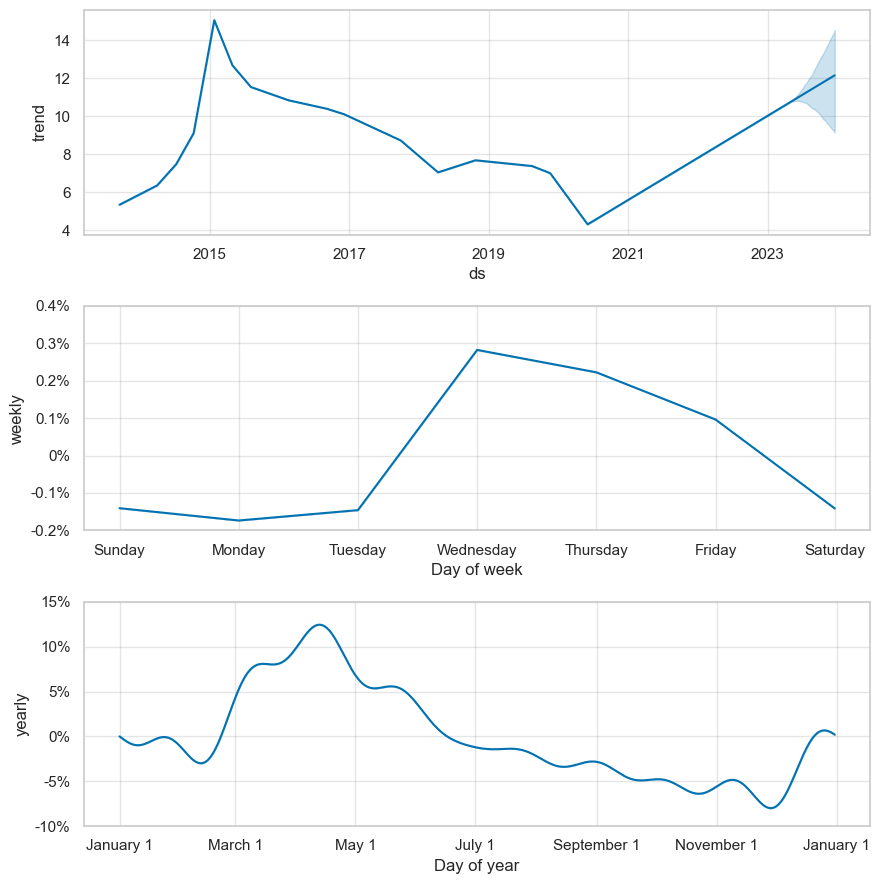

In [154]:
fig = final_test_model.plot_components(forecast)

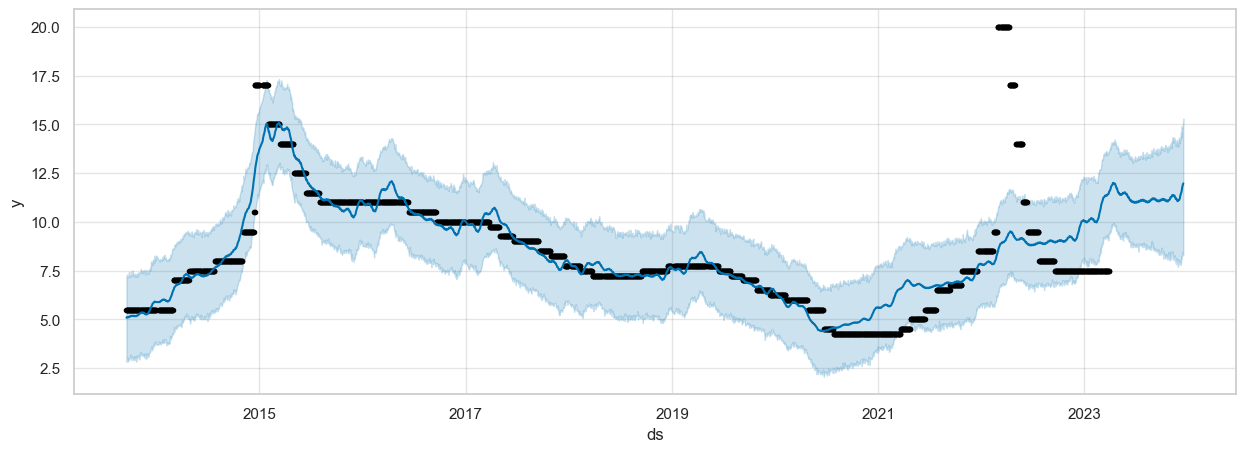

In [155]:
# смотрим график прогноза с grid
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

In [156]:
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
258,2024-04-04,14.242636,8.566243,19.785176
259,2024-04-05,14.271274,8.900556,19.869532
260,2024-04-08,14.354170,8.758760,19.843151
261,2024-04-09,14.388610,8.703890,20.168237
262,2024-04-10,14.469219,8.714520,19.940956


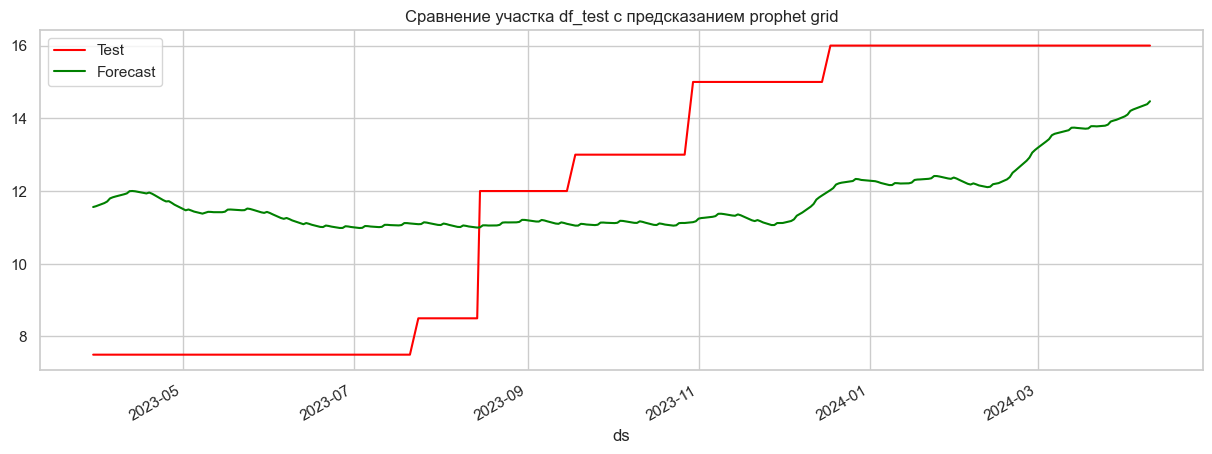

In [157]:
# сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [158]:
# сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet,2.963564,0.277150,9.632522,3.103630
0,Prophet_with_holidays,2.956280,0.276899,9.613325,3.100536
0,Prophet_with_grid,3.057408,0.280506,10.136631,3.183808
0,Prophet_with_grid,3.052226,0.288947,10.401220,3.225092


In [159]:
# Сохранение DataFrame df в файл data/df.csv
df.to_csv('../data/df.csv', index=False)

# Сохранение DataFrame df_train в файл data/df_train.csv
df_train.to_csv('../data/df_train.csv', index=False)

# Сохранение DataFrame df_test в файл data/df_test.csv
df_test.to_csv('../data/df_test.csv', index=False)


In [160]:
# Сохранение модели в JSON файл
with open('../backend/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))